# Preparing Library and Modules

In [ ]:
!pip install catboost
!pip install optuna
!pip install shap

In [ ]:

# General
import numpy as np
import pandas as pd
import os

# Graph
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score, accuracy_score
from imblearn.over_sampling import SMOTE
import optuna
import shap

In [ ]:
RANDOM_STATE = 42

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

# EDA

In [ ]:
def check_dataframe_abnormalities(df):
    """
    Check for abnormalities in a pandas DataFrame, including null values, NA values, and more.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    dict: A dictionary containing the abnormalities found in the DataFrame.
    """
    abnormalities = {}

    # Check for null values
    null_values = df.isnull().sum()
    if null_values.any():
        abnormalities['null_values'] = null_values[null_values > 0]

    # Check for NA values
    na_values = df.isna().sum()
    if na_values.any():
        abnormalities['na_values'] = na_values[na_values > 0]

    # Check for infinite values
    inf_values = df.map(lambda x: x == float('inf')).sum()
    if inf_values.any():
        abnormalities['infinite_values'] = inf_values[inf_values > 0]

    # Check for -infinite values
    neg_inf_values = df.map(lambda x: x == float('-inf')).sum()
    if neg_inf_values.any():
        abnormalities['negative_infinite_values'] = neg_inf_values[neg_inf_values > 0]

    # Check for duplicated rows
    duplicated_rows = df.duplicated().sum()
    if duplicated_rows > 0:
        abnormalities['duplicated_rows'] = duplicated_rows

    # Check for columns with only one unique value (constant columns)
    constant_columns = df.nunique() == 1
    if constant_columns.any():
        abnormalities['constant_columns'] = df.columns[constant_columns].tolist()

    return abnormalities

## Train

In [ ]:
train

id                origin_host  origin_port  \
0        CkwI1TlUCRApPfcJl              103.255.15.27        45314   
1       CBlrcc3dvtaHzyV4zj              103.255.15.27        45060   
2       CdpSX33u29yjDvnVzi              103.255.15.23         3440   
3       CT23VJ1KsoKeCdWpx2             103.255.15.150        56132   
4       C6OJU51P50bwNKvnY6             103.255.15.150        43358   
...                    ...                        ...          ...   
416468  COacmK2gmfhhWCrh73             103.255.15.150        53314   
416469   CUxjxWgzdF71Y5kXc              103.255.15.23        59005   
416470  CUU9WM3olirlj8Absj              103.255.15.23         7978   
416471  ChiYNu2wqDXFBTzHV4  fe80::c1a7:7791:969e:3c06        55784   
416472   CGxFa3txgPqmwWDFh              103.255.15.23         5192   

             response_host  response_port  flow_duration  \
0            103.255.15.23          42001       0.000090   
1            103.255.15.23          42000       0.000033   
2             52.45.16.192            443      61.977190   
3                  8.8.8.8             53       0.024249   
4                  8.8.8.8             53       0.027580   
...                    ...            ...            ...   
416468     128.199.242.104            443            NaN   
416469             8.8.8.8             53            NaN   
416470       128.199.88.81            443            NaN   
416471  2600:1901:0:38d7::             80       0.000000   
416472     128.199.242.104            443            NaN   

        forward_packets_per_sec  backward_packets_per_sec  \
0                  11125.474801                       NaN   
1                  30174.848921              30174.848921   
2                      0.322699                  0.242025   
3                           NaN                 82.478178   
4                           NaN                       NaN   
...                         ...                       ...   
416468                28.153470                 36.599511   
416469                      NaN                 80.762198   
416470                46.391519                       NaN   
416471                 0.000000                  0.000000   
416472                      NaN                       NaN   

        flow_packets_per_sec  down_up_ratio  ...  forward_bulk_packets  \
0               22250.949602       1.000000  ...                   0.0   
1               60349.697842       1.000000  ...                   0.0   
2                   0.564724       0.750000  ...                   NaN   
3                 164.956355       1.000000  ...                   NaN   
4                  72.516256            NaN  ...                   0.0   
...                      ...            ...  ...                   ...   
416468                   NaN       1.300000  ...                   0.0   
416469                   NaN       1.000000  ...                   0.0   
416470             90.658236       0.954198  ...                   NaN   
416471              0.000000            NaN  ...                   0.0   
416472             12.338441       0.928571  ...                   0.0   

        backward_bulk_packets  forward_bulk_rate  backward_bulk_rate  \
0                         0.0                NaN        0.000000e+00   
1                         0.0                0.0        0.000000e+00   
2                         0.0                NaN        0.000000e+00   
3                         0.0                0.0        0.000000e+00   
4                         0.0                NaN        0.000000e+00   
...                       ...                ...                 ...   
416468                    5.0                0.0        1.092664e+08   
416469                    0.0                NaN        0.000000e+00   
416470                  113.0                0.0        2.262403e+05   
416471                    0.0                0.0        0.000000e+00   
416472                    0.0                0.0

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            416473 non-null  object 
 1   origin_host                   416473 non-null  object 
 2   origin_port                   416473 non-null  int64  
 3   response_host                 416473 non-null  object 
 4   response_port                 416473 non-null  int64  
 5   flow_duration                 299409 non-null  float64
 6   forward_packets_per_sec       293081 non-null  float64
 7   backward_packets_per_sec      324234 non-null  float64
 8   flow_packets_per_sec          304723 non-null  float64
 9   down_up_ratio                 292858 non-null  float64
 10  flow_FIN_flags                304424 non-null  float64
 11  flow_SYN_flags                325463 non-null  float64
 12  flow_RST_flags                311037 non-nul

In [ ]:
print(train.describe())

         origin_port  response_port  flow_duration  forward_packets_per_sec  \
count  416473.000000  416473.000000  299409.000000            293081.000000   
mean    38683.205413    5100.549457       9.661306              1843.291061   
std     18072.735011   12938.833174     105.893481              5082.812608   
min        21.000000       0.000000       0.000000                 0.000000   
25%     28646.000000      53.000000       0.000149                 3.655525   
50%     42700.000000     443.000000       0.025976                39.527141   
75%     53137.000000     443.000000       0.340028                80.680638   
max     65535.000000   65522.000000   17393.030600            223696.213333   

       backward_packets_per_sec  flow_packets_per_sec  down_up_ratio  \
count             324234.000000         304723.000000  292858.000000   
mean                1644.112145           3324.893938       0.884547   
std                 4516.829821           9299.108522       0.530388   


In [ ]:
print(check_dataframe_abnormalities(train).keys())

dict_keys(['null_values', 'na_values'])


## Test

In [ ]:
test

id      origin_host  origin_port    response_host  \
0       ClDOIi3yLGMfeRPzAc    103.255.15.23        49188    13.227.228.83   
1       C9chsd1cHTOBBHe6Q2  202.169.224.219         5678  255.255.255.255   
2       CUOe3U1NC5Nln7cItf   103.255.15.150        32976          8.8.8.8   
3       C6QhB04KTRUYOY2rMk   103.255.15.150        48606  128.199.242.104   
4       C60oC51SZNEhCXlX6c   103.255.15.150        34794  128.199.242.104   
...                    ...              ...          ...              ...   
138800  CWXgM92AOvagYVekD3    103.255.15.67        52975    103.255.15.23   
138801  CMmDuU3aNTnOz4ZwSi    103.255.15.27        37214    103.255.15.23   
138802  CQO5h64B0lXTYRlsNf   103.255.15.150        38336          8.8.8.8   
138803  CWZZN23jtBV7sZsBLi   103.255.15.150        37267          8.8.8.8   
138804  CAYAeJ26bhNrdT6KVc   103.255.15.150        50399          8.8.8.8   

        response_port  flow_duration  forward_packets_per_sec  \
0                 443       1.738424                 8.628505   
1                5678       0.000000                 0.000000   
2                  53            NaN                80.446972   
3                 443            NaN                      NaN   
4                 443       0.326490                30.628816   
...               ...            ...                      ...   
138800            161            NaN              7307.149826   
138801          42001       0.000144              6944.211921   
138802             53            NaN                      NaN   
138803             53       0.025681                77.878530   
138804             53       0.023551                84.922130   

        backward_packets_per_sec  flow_packets_per_sec  down_up_ratio  ...  \
0                            NaN             16.681776            NaN  ...   
1                       0.000000              0.000000            0.0  ...   
2                            NaN                   NaN            1.0  ...   
3                      51.891033             88.956056            NaN  ...   
4                            NaN             70.446278            1.3  ...   
...                          ...                   ...            ...  ...   
138800                       NaN                   NaN            1.0  ...   
138801                       NaN                   NaN            1.0  ...   
138802                 33.424744                   NaN            1.0  ...   
138803                       NaN            155.757060            NaN  ...   
138804                 84.922130                   NaN            NaN  ...   

        backward_bulk_bytes  forward_bulk_packets  backward_bulk_packets  \
0                       0.0                   0.0                    NaN   
1                       NaN                   0.0                    NaN   
2                       0.0                   NaN                    0.0   
3                    4585.0                   0.0                    5.0   
4                    4585.0                   0.0                    NaN   
...                     ...                   ...                    ...   
138800                  0.0                   0.0                    0.0   
138801                  NaN                   NaN                    0.0   
138802                  0.0                   0.0                    0.0   
138803                  0.0                   0.0                    0.0   
138804                  0.0                   0.0                    0.0   

        forward_bulk_rate  backward_bulk_rate        active  idle  \
0                     NaN        0.000000e+00  1.738440e+06   NaN   
1                     NaN                 NaN  0.000000e+00   0.0   
2                     0.0        0.000000e+00  2.486110e+04   0.0   
3                     0.0        1.544649e+07  2.697961e+05   0.0   
4                     NaN        5.211622e+07           NaN   NaN   
...                   ...                 ...         

In [ ]:
test.describe()

origin_port  response_port  flow_duration  forward_packets_per_sec  \
count  138805.000000  138805.000000   86780.000000             96316.000000   
mean    38643.171716    5026.990533       8.998870              1694.462380   
std     18069.127007   12846.383380      74.040612              5000.359246   
min        21.000000       0.000000       0.000000                 0.000000   
25%     28397.000000      53.000000       0.000289                 4.378346   
50%     42678.000000     443.000000       0.026065                39.616277   
75%     53066.000000     443.000000       0.342185                80.286630   
max     65535.000000   65476.000000   13544.854760            199728.761905   

       backward_packets_per_sec  flow_packets_per_sec  down_up_ratio  \
count              91138.000000          90465.000000   98791.000000   
mean                1617.813103           3361.688141       0.885699   
std                 4539.259911           9289.424680       0.530735   
min                    0.000000              0.000000       0.000000   
25%                    3.267937              7.379475       0.857143   
50%                   43.898407             82.657785       1.000000   
75%                   80.044733            160.526016       1.000000   
max               110376.421053         199728.761905       6.000000   

       flow_FIN_flags  flow_SYN_flags  flow_RST_flags  ...  \
count   115082.000000   108899.000000    93683.000000  ...   
mean         0.566674        0.908392        0.504275  ...   
std          0.822711        1.024548        0.940588  ...   
min          0.000000        0.000000        0.000000  ...   
25%          0.000000        0.000000        0.000000  ...   
50%          0.000000        1.000000        0.000000  ...   
75%          1.000000        2.000000        1.000000  ...   
max         14.000000       23.000000      110.000000  ...   

       backward_bulk_bytes  forward_bulk_packets  backward_bulk_packets  \
count         9.643100e+04          93169.000000           99196.000000   
mean          6.830053e+03              0.030429               2.562582   
std           8.004836e+04              0.516207              16.548831   
min           0.000000e+00              0.000000               0.000000   
25%           0.000000e+00              0.000000               0.000000   
50%           0.000000e+00              0.000000               0.000000   
75%           0.000000e+00              0.000000               0.000000   
max           1.178772e+07             37.000000            2792.000000   

       forward_bulk_rate  backward_bulk_rate        active          idle  \
count       8.803000e+04        9.755200e+04  9.878200e+04  1.073320e+05   
mean        1.234917e+03        5.743511e+06  7.188082e+05  4.115266e+06   
std         6.375254e+04        1.878293e+07  4.344091e+06  1.926570e+07   
min         0.000000e+00        0.000000e+00  0.000000e+00  0.000000e+00   
25%         0.000000e+00        0.000000e+00  1.902580e+02  0.000000e+00   
50%         0.000000e+00        0.000000e+00  2.588487e+04  0.000000e+00   
75%         0.000000e+00        0.000000e+00  2.778430e+05  0.000000e+00   
max         1.233944e+07        2.721853e+08  5.712282e+08  2.979973e+08   

       forward_initial_window_size  backward_initial_window_size  \
count                102221.000000                 117664.000000   
mean                  14758.922775                  20520.201514   
std                   15004.010426                  28926.969165   
min                       0.000000                      0.000000   
25%                       0.000000                      0.000000   
50%                    5840.000000                      0.000000   
75%                   29200.000000                  65160.000000   
max                   65535.000000                  65535.000000   

       forward_last_window_size  
count              99648.000000  
mean                4532.617825  
std          

In [ ]:
print(check_dataframe_abnormalities(test).keys)

<built-in method keys of dict object at 0x7d2e1ecf15c0>


# Data Preprocessing

Dari beberapa observasi yang ditemukan,terdapat beberapa hal yang perlu dilakukan sebelum data Train dapat dilakukan Machine Learning:
1. Mengatasi missing value **(Solve: diisi dengan nilai -1)**
2. Mengatasi kolom object seperti response_host dan origin_host **(Solve: encode melalui frequency encoding)**

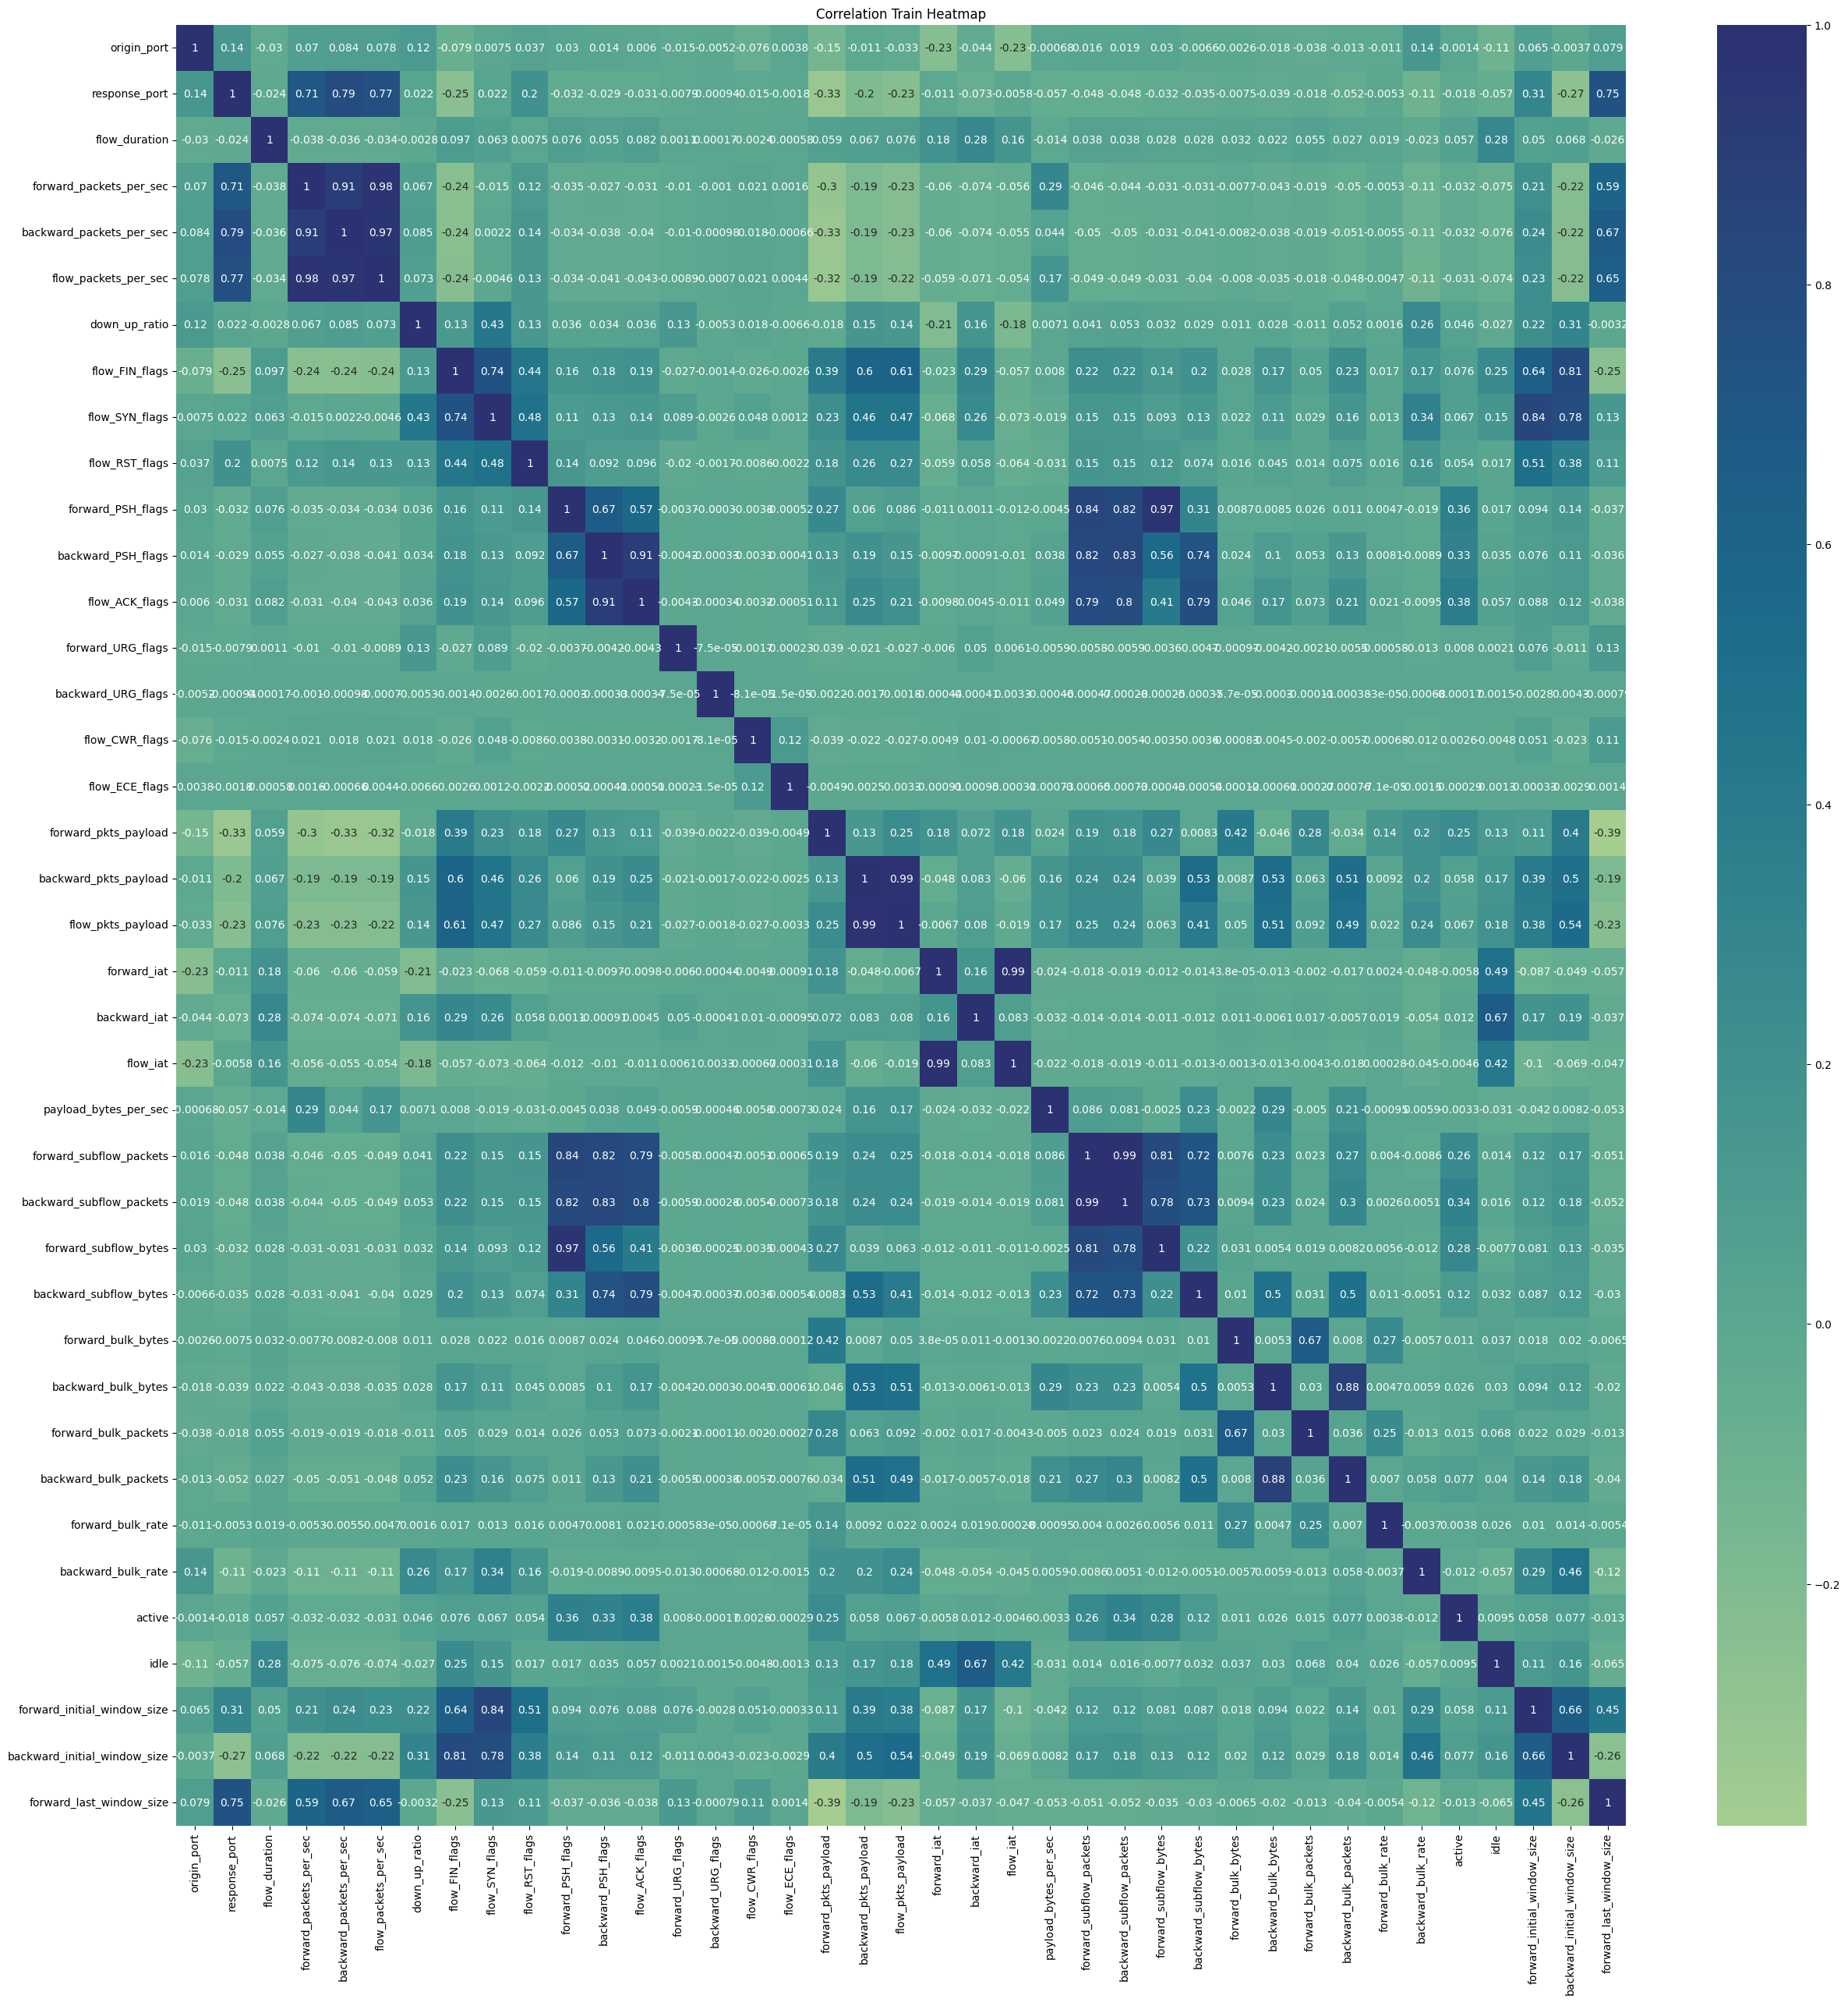

In [ ]:
numeric_df = train.select_dtypes(include=[float, int])
plt.figure(figsize=(30,30))
sns.heatmap(numeric_df.corr(), cmap="crest", annot=True)
plt.title("Correlation Train Heatmap")
plt.show()

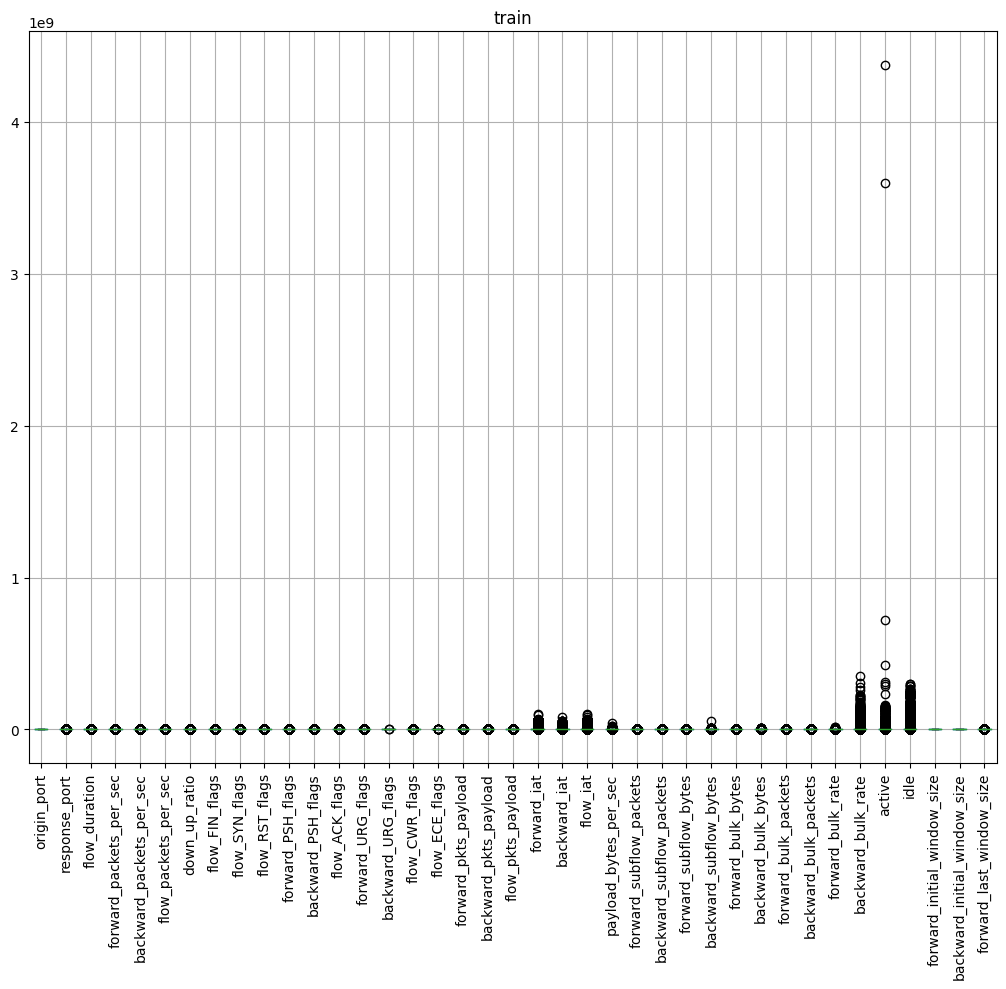

In [ ]:
plt.figure(figsize=(20, 10))

train_copy = train.copy()

# boxplot untuk df_normalized
plt.subplot(1, 2, 1)
# train_clean['Price'] = train_clean['Price_log'].copy()
# train_clean = train_clean.drop(columns=['id'])
train_copy = train_copy.drop(columns=['id'])
train_copy.boxplot()
plt.title('train')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            416473 non-null  object 
 1   origin_host                   416473 non-null  object 
 2   origin_port                   416473 non-null  int64  
 3   response_host                 416473 non-null  object 
 4   response_port                 416473 non-null  int64  
 5   flow_duration                 299409 non-null  float64
 6   forward_packets_per_sec       293081 non-null  float64
 7   backward_packets_per_sec      324234 non-null  float64
 8   flow_packets_per_sec          304723 non-null  float64
 9   down_up_ratio                 292858 non-null  float64
 10  flow_FIN_flags                304424 non-null  float64
 11  flow_SYN_flags                325463 non-null  float64
 12  flow_RST_flags                311037 non-nul

## Data Cleaning (Train)

### Impute

In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=8c4c65378bc5fa4e3d486c407d8497018ba1b8888a33d2e0c0295e6f32dbf06b
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=e5e3f219f60b49405f2ff2b434a6573a60a73ddd568222f26d75c2f4b2beadab
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
import pandas as pd
from fancyimpute import IterativeImputer as MICE
from sklearn.impute import SimpleImputer

# Inisialisasi MICE imputer
mice_imputer = MICE(random_state=RANDOM_STATE)

# Inisialisasi Robust Imputer
robust_imputer = SimpleImputer(strategy='median')  # Robust terhadap outlier

# Copy dataframe untuk melakukan imputasi
train_clean = train.copy()

# Kolom yang memerlukan imputasi robust
robust_columns = [
    'forward_iat', 'backward_iat', 'flow_iat',
    'payload_bytes_per_sec', 'backward_subflow_bytes', 'backward_bulk_bytes', 'forward_bulk_rate',
    'backward_bulk_rate', 'active', 'idle'
]

# Kolom yang memerlukan imputasi MICE
columns_to_impute = [
    col for col in train_clean.columns if train_clean[col].dtype in ['float64', 'int64']
    and train_clean[col].isnull().any()
    and col not in robust_columns
]

# Imputasi robust
train_clean[robust_columns] = robust_imputer.fit_transform(train_clean[robust_columns])

# Imputasi MICE
train_clean[columns_to_impute] = mice_imputer.fit_transform(train_clean[columns_to_impute])

# Tampilkan hasil untuk memeriksa apakah nilai yang hilang sudah terisi
print(train_clean.isnull().sum())


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


id                              0
origin_host                     0
origin_port                     0
response_host                   0
response_port                   0
flow_duration                   0
forward_packets_per_sec         0
backward_packets_per_sec        0
flow_packets_per_sec            0
down_up_ratio                   0
flow_FIN_flags                  0
flow_SYN_flags                  0
flow_RST_flags                  0
forward_PSH_flags               0
backward_PSH_flags              0
flow_ACK_flags                  0
forward_URG_flags               0
backward_URG_flags              0
flow_CWR_flags                  0
flow_ECE_flags                  0
forward_pkts_payload            0
backward_pkts_payload           0
flow_pkts_payload               0
forward_iat                     0
backward_iat                    0
flow_iat                        0
payload_bytes_per_sec           0
forward_subflow_packets         0
backward_subflow_packets        0
forward_subflo

In [ ]:
# Cetak hasil imputasi
train_clean.to_csv("train_clean_v7.csv",index=False)

In [ ]:
# Import imputed dari csv
train_clean = pd.read_csv("/content/train_clean_v7.csv")

### Encode

In [ ]:
# Label encoder instance
traffic_le = LabelEncoder()

# Encode
train_clean["traffic"] = traffic_le.fit_transform(train_clean["traffic"])
train_clean["traffic"] = train_clean["traffic"].astype(int)
train_clean

id                origin_host  origin_port  \
0        CkwI1TlUCRApPfcJl              103.255.15.27        45314   
1       CBlrcc3dvtaHzyV4zj              103.255.15.27        45060   
2       CdpSX33u29yjDvnVzi              103.255.15.23         3440   
3       CT23VJ1KsoKeCdWpx2             103.255.15.150        56132   
4       C6OJU51P50bwNKvnY6             103.255.15.150        43358   
...                    ...                        ...          ...   
416468  COacmK2gmfhhWCrh73             103.255.15.150        53314   
416469   CUxjxWgzdF71Y5kXc              103.255.15.23        59005   
416470  CUU9WM3olirlj8Absj              103.255.15.23         7978   
416471  ChiYNu2wqDXFBTzHV4  fe80::c1a7:7791:969e:3c06        55784   
416472   CGxFa3txgPqmwWDFh              103.255.15.23         5192   

             response_host  response_port  flow_duration  \
0            103.255.15.23          42001       0.000090   
1            103.255.15.23          42000       0.000033   
2             52.45.16.192            443      61.977190   
3                  8.8.8.8             53       0.024249   
4                  8.8.8.8             53       0.027580   
...                    ...            ...            ...   
416468     128.199.242.104            443      22.615478   
416469             8.8.8.8             53       2.734484   
416470       128.199.88.81            443      83.546378   
416471  2600:1901:0:38d7::             80       0.000000   
416472     128.199.242.104            443      17.342132   

        forward_packets_per_sec  backward_packets_per_sec  \
0                  11125.474801              11129.187301   
1                  30174.848921              30174.848921   
2                      0.322699                  0.242025   
3                     83.567618                 82.478178   
4                   -161.367332                233.105711   
...                         ...                       ...   
416468                28.153470                 36.599511   
416469               442.084512                 80.762198   
416470                46.391519                 31.721063   
416471                 0.000000                  0.000000   
416472              -509.868398                518.214266   

        flow_packets_per_sec  down_up_ratio  ...  forward_bulk_packets  \
0               22250.949602       1.000000  ...              0.000000   
1               60349.697842       1.000000  ...              0.000000   
2                   0.564724       0.750000  ...             -0.214788   
3                 164.956355       1.000000  ...              0.022794   
4                  72.516256       0.741206  ...              0.000000   
...                      ...            ...  ...                   ...   
416468             60.260472       1.300000  ...              0.000000   
416469            522.000917       1.000000  ...              0.000000   
416470             90.658236       0.954198  ...              0.144493   
416471              0.000000       0.244735  ...              0.000000   
416472             12.338441       0.928571  ...              0.000000   

        backward_bulk_packets  forward_bulk_rate  backward_bulk_rate  \
0                         0.0                0.0        0.000000e+00   
1                         0.0                0.0        0.000000e+00   
2                         0.0                0.0        0.000000e+00   
3                         0.0                0.0        0.000000e+00   
4                         0.0                0.0        0.000000e+00   
...                       ...                ...                 ...   
416468                    5.0                0.0        1.092664e+08   
416469                    0.0                0.0        0.000000e+00   
416470                  113.0                0.0        2.262403e+05   
416471                    0.0                0.0        0.000000e+00   
416472                    0.0                0.0

In [ ]:
# Frequency Encoding
response_total = pd.concat([train['response_host'], test['response_host']])
origin_total = pd.concat([train['origin_host'], test['origin_host']])
response_freq = response_total.value_counts() / len(response_total)
origin_freq = origin_total.value_counts() / len(response_total)
train_clean['origin_frequency'] = train_clean['origin_host'].map(origin_freq)
train_clean['response_frequency'] = train_clean['response_host'].map(response_freq)
train_clean

id                origin_host  origin_port  \
0        CkwI1TlUCRApPfcJl              103.255.15.27        45314   
1       CBlrcc3dvtaHzyV4zj              103.255.15.27        45060   
2       CdpSX33u29yjDvnVzi              103.255.15.23         3440   
3       CT23VJ1KsoKeCdWpx2             103.255.15.150        56132   
4       C6OJU51P50bwNKvnY6             103.255.15.150        43358   
...                    ...                        ...          ...   
416468  COacmK2gmfhhWCrh73             103.255.15.150        53314   
416469   CUxjxWgzdF71Y5kXc              103.255.15.23        59005   
416470  CUU9WM3olirlj8Absj              103.255.15.23         7978   
416471  ChiYNu2wqDXFBTzHV4  fe80::c1a7:7791:969e:3c06        55784   
416472   CGxFa3txgPqmwWDFh              103.255.15.23         5192   

             response_host  response_port  flow_duration  \
0            103.255.15.23          42001       0.000090   
1            103.255.15.23          42000       0.000033   
2             52.45.16.192            443      61.977190   
3                  8.8.8.8             53       0.024249   
4                  8.8.8.8             53       0.027580   
...                    ...            ...            ...   
416468     128.199.242.104            443      22.615478   
416469             8.8.8.8             53       2.734484   
416470       128.199.88.81            443      83.546378   
416471  2600:1901:0:38d7::             80       0.000000   
416472     128.199.242.104            443      17.342132   

        forward_packets_per_sec  backward_packets_per_sec  \
0                  11125.474801              11129.187301   
1                  30174.848921              30174.848921   
2                      0.322699                  0.242025   
3                     83.567618                 82.478178   
4                   -161.367332                233.105711   
...                         ...                       ...   
416468                28.153470                 36.599511   
416469               442.084512                 80.762198   
416470                46.391519                 31.721063   
416471                 0.000000                  0.000000   
416472              -509.868398                518.214266   

        flow_packets_per_sec  down_up_ratio  ...  forward_bulk_rate  \
0               22250.949602       1.000000  ...                0.0   
1               60349.697842       1.000000  ...                0.0   
2                   0.564724       0.750000  ...                0.0   
3                 164.956355       1.000000  ...                0.0   
4                  72.516256       0.741206  ...                0.0   
...                      ...            ...  ...                ...   
416468             60.260472       1.300000  ...                0.0   
416469            522.000917       1.000000  ...                0.0   
416470             90.658236       0.954198  ...                0.0   
416471              0.000000       0.244735  ...                0.0   
416472             12.338441       0.928571  ...                0.0   

        backward_bulk_rate        active          idle  \
0             0.000000e+00  8.988380e+01  0.000000e+00   
1             0.000000e+00  3.314018e+01  0.000000e+00   
2             0.000000e+00  4.010890e+05  9.861604e+06   
3             0.000000e+00  2.424884e+04  0.000000e+00   
4             0.000000e+00  2.758002e+04  0.000000e+00   
...                    ...           ...           ...   
416468        1.092664e+08  3.551960e+05  0.000000e+00   
416469        0.000000e+00  2.476406e+04  0.000000e+00   
416470        2.262403e+05  2.823808e+06  0.000000e+00   
416471        0.000000e+00  0.000000e+00  0.000000e+00   
416472        0.000000e+00  2.188294e+06  0.000000e+00   

        forward_initial_window_size  backward_initial_window_size  \
0                      29200.000000                  13473.596616   
1                      29200.000000      

In [ ]:
print(check_dataframe_abnormalities(train_clean).keys())

dict_keys([])


In [ ]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            416473 non-null  object 
 1   origin_host                   416473 non-null  object 
 2   origin_port                   416473 non-null  int64  
 3   response_host                 416473 non-null  object 
 4   response_port                 416473 non-null  int64  
 5   flow_duration                 416473 non-null  float64
 6   forward_packets_per_sec       416473 non-null  float64
 7   backward_packets_per_sec      416473 non-null  float64
 8   flow_packets_per_sec          416473 non-null  float64
 9   down_up_ratio                 416473 non-null  float64
 10  flow_FIN_flags                416473 non-null  float64
 11  flow_SYN_flags                416473 non-null  float64
 12  flow_RST_flags                416473 non-nul

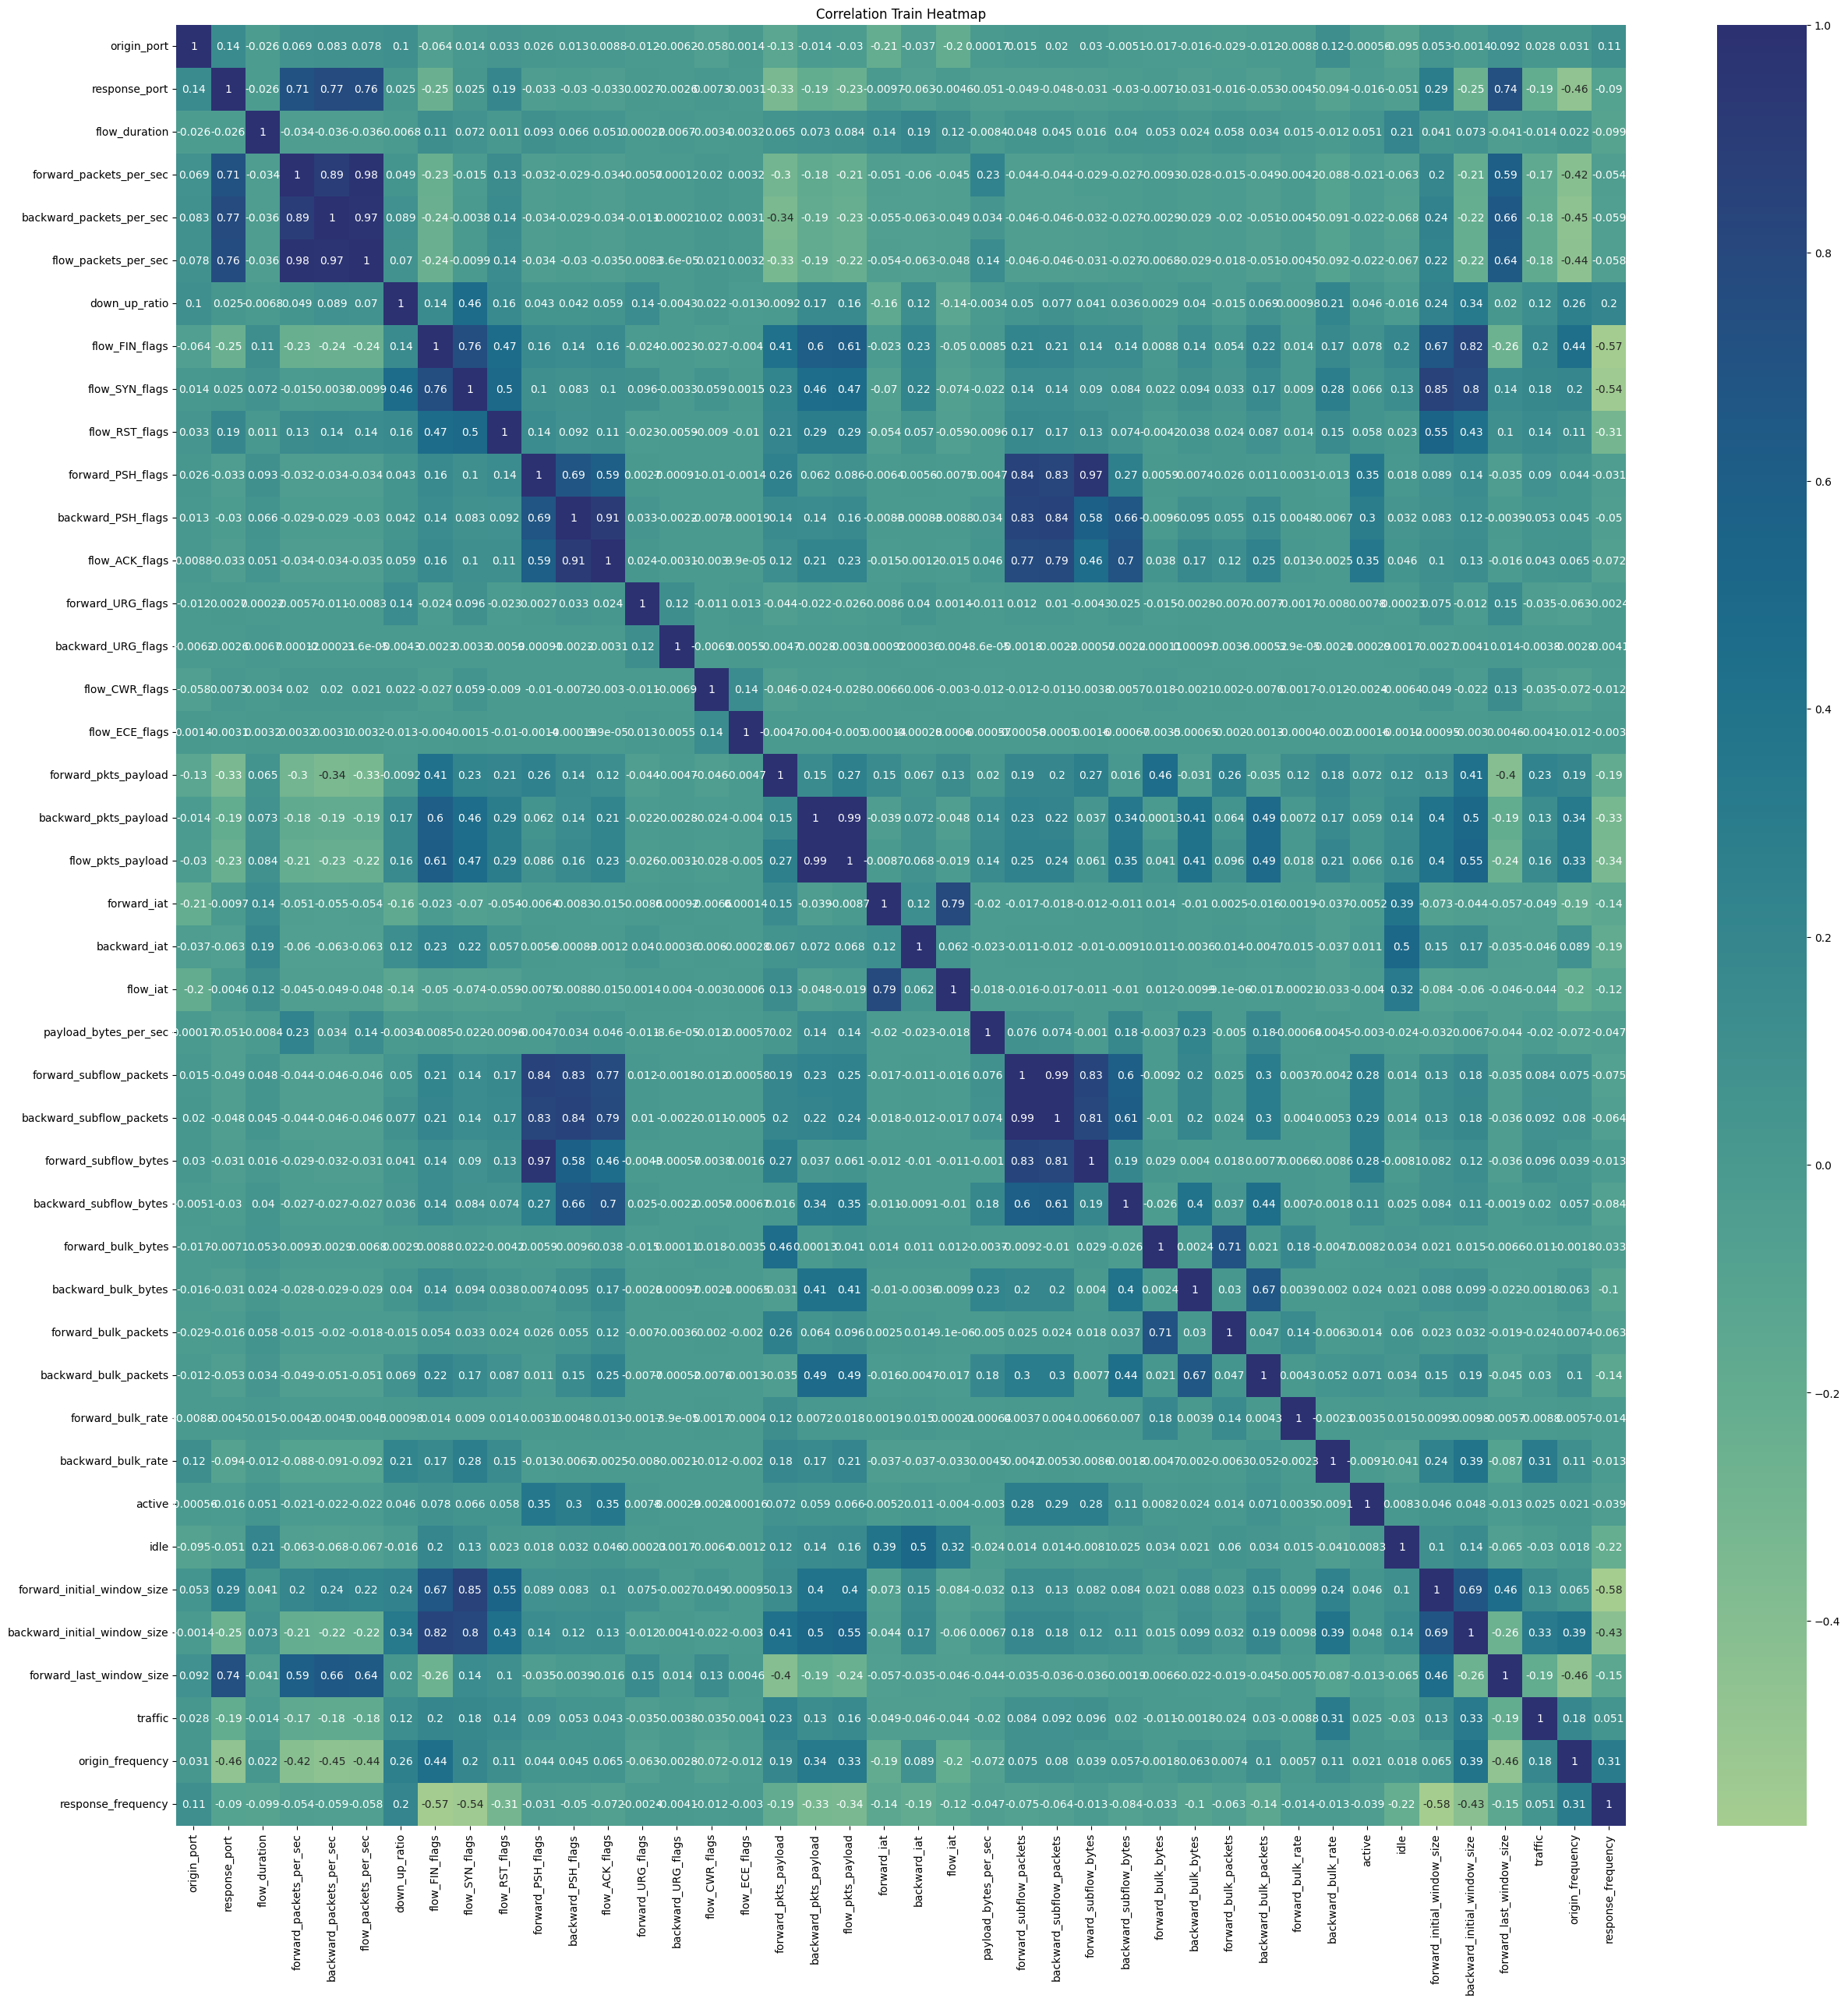

In [ ]:
numeric_df = train_clean.select_dtypes(include=[float, int])
plt.figure(figsize=(30,30))
sns.heatmap(numeric_df.corr(), cmap="crest", annot=True)
plt.title("Correlation Train Heatmap")
plt.show()

In [ ]:
# Drop
# train_clean = train_clean.copy().drop(['response_host','origin_host','forward_URG_flags', 'backward_URG_flags', 'flow_CWR_flags', 'flow_ECE_flags', 'forward_bulk_bytes', 'forward_bulk_packets', 'forward_bulk_rate'],axis=1)
train_clean = train_clean.copy().drop(['response_host','origin_host','forward_URG_flags', 'backward_URG_flags', 'flow_CWR_flags', 'flow_ECE_flags', 'flow_packets_per_sec', 'flow_ACK_flags', 'flow_pkts_payload', 'flow_iat', 'forward_PSH_flags', 'backward_subflow_packets', 'forward_packets_per_sec', 'forward_initial_window_size', 'forward_subflow_packets', 'backward_initial_window_size'],axis=1)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        416473 non-null  object 
 1   origin_port               416473 non-null  int64  
 2   response_port             416473 non-null  int64  
 3   flow_duration             416473 non-null  float64
 4   backward_packets_per_sec  416473 non-null  float64
 5   down_up_ratio             416473 non-null  float64
 6   flow_FIN_flags            416473 non-null  float64
 7   flow_SYN_flags            416473 non-null  float64
 8   flow_RST_flags            416473 non-null  float64
 9   backward_PSH_flags        416473 non-null  float64
 10  forward_pkts_payload      416473 non-null  float64
 11  backward_pkts_payload     416473 non-null  float64
 12  forward_iat               416473 non-null  float64
 13  backward_iat              416473 non-null  f

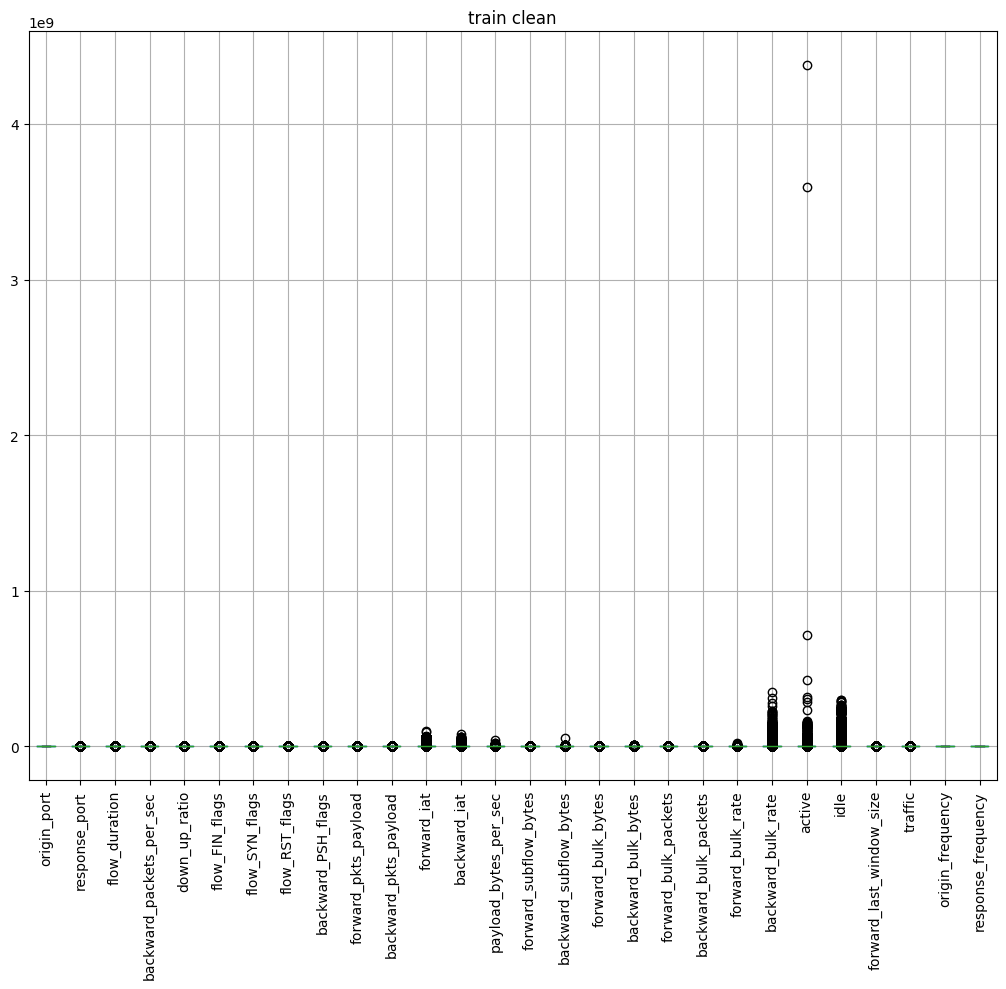

In [ ]:
plt.figure(figsize=(20, 10))

train_clean_copy = train_clean.copy()

# boxplot untuk df_normalized
plt.subplot(1, 2, 1)
# train_clean['Price'] = train_clean['Price_log'].copy()
# train_clean = train_clean.drop(columns=['id'])
train_clean_copy = train_clean_copy.drop(columns=['id'])
train_clean_copy.boxplot()
plt.title('train clean')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

columns_to_log_transform = ['backward_iat', 'forward_iat',
                            'payload_bytes_per_sec',
                            'backward_bulk_rate', 'active', 'idle']

for col in columns_to_log_transform:
    train_clean[col] = np.log1p(train_clean[col])


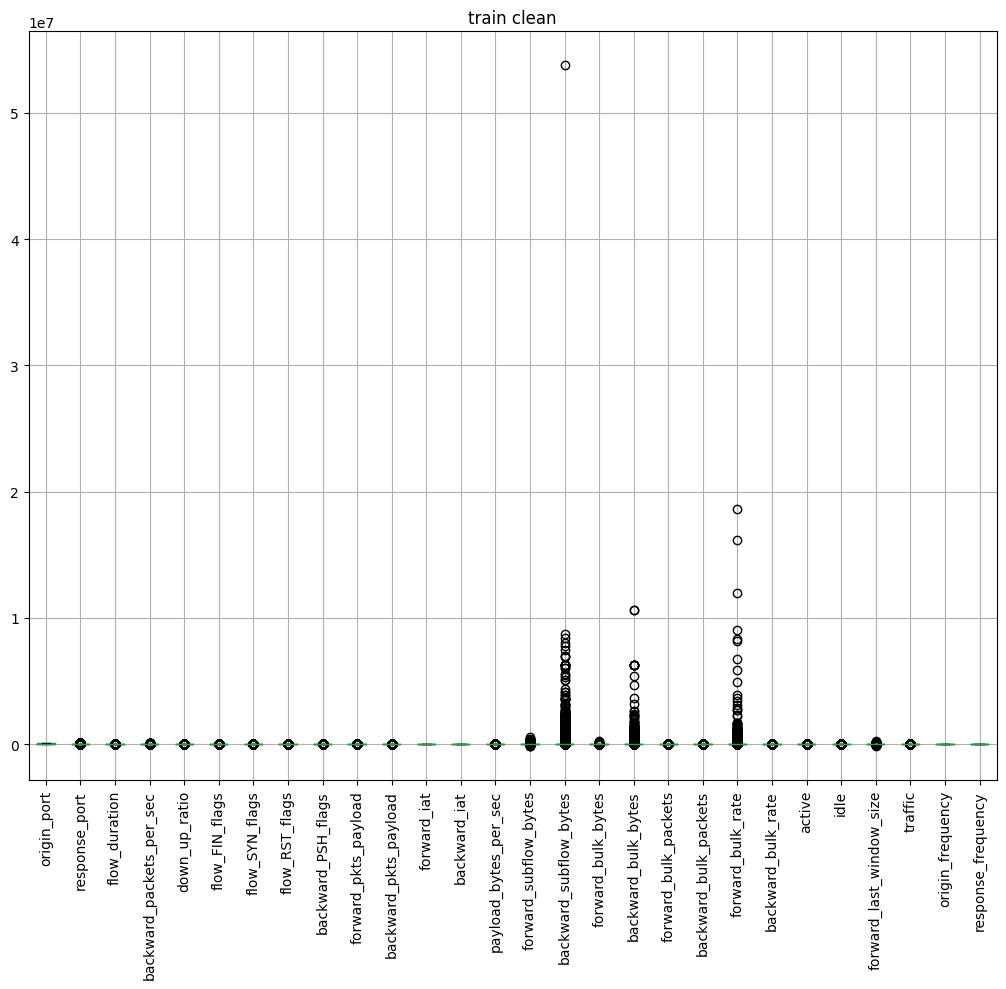

In [ ]:
plt.figure(figsize=(20, 10))

train_clean_copy = train_clean.copy()

# boxplot untuk df_normalized
plt.subplot(1, 2, 1)
# train_clean['Price'] = train_clean['Price_log'].copy()
# train_clean = train_clean.drop(columns=['id'])
train_clean_copy = train_clean_copy.drop(columns=['id'])
train_clean_copy.boxplot()
plt.title('train clean')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [ ]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416473 entries, 0 to 416472
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        416473 non-null  object 
 1   origin_port               416473 non-null  int64  
 2   response_port             416473 non-null  int64  
 3   flow_duration             416473 non-null  float64
 4   backward_packets_per_sec  416473 non-null  float64
 5   down_up_ratio             416473 non-null  float64
 6   flow_FIN_flags            416473 non-null  float64
 7   flow_SYN_flags            416473 non-null  float64
 8   flow_RST_flags            416473 non-null  float64
 9   backward_PSH_flags        416473 non-null  float64
 10  forward_pkts_payload      416473 non-null  float64
 11  backward_pkts_payload     416473 non-null  float64
 12  forward_iat               416473 non-null  float64
 13  backward_iat              416473 non-null  f

In [ ]:
train_clean.describe()

origin_port  response_port  flow_duration  backward_packets_per_sec  \
count  416473.000000  416473.000000  416473.000000             416473.000000   
mean    38683.205413    5100.549457       9.861627               1664.622504   
std     18072.735011   12938.833174      97.281883               4371.495413   
min        21.000000       0.000000   -5552.372504              -5912.699797   
25%     28646.000000      53.000000       0.000271                  5.374735   
50%     42700.000000     443.000000       0.178526                 49.246883   
75%     53137.000000     443.000000       4.296239                 84.384794   
max     65535.000000   65522.000000   17393.030600              88768.338624   

       down_up_ratio  flow_FIN_flags  flow_SYN_flags  flow_RST_flags  \
count  416473.000000   416473.000000   416473.000000   416473.000000   
mean        0.880513        0.561477        0.918416        0.498062   
std         0.492938        0.811239        0.998242        0.847442   
min       -10.123536      -11.808698      -18.168273      -22.987179   
25%         0.729016        0.000000        0.000000        0.000000   
50%         1.000000        0.000000        1.000000        0.000000   
75%         1.000000        1.000000        2.000000        1.000000   
max        18.540190       15.000000       23.000000      101.000000   

       backward_PSH_flags  forward_pkts_payload  ...  forward_bulk_packets  \
count       416473.000000         416473.000000  ...         416473.000000   
mean            10.798244             52.587438  ...              0.029003   
std            123.798262             51.149245  ...              0.507317   
min           -831.833842          -1530.440629  ...            -17.943902   
25%              0.000000             35.000000  ...              0.000000   
50%              0.000000             41.414522  ...              0.000000   
75%              5.000000             80.787132  ...              0.000000   
max          48653.000000           5117.348552  ...             89.500000   

       backward_bulk_packets  forward_bulk_rate  backward_bulk_rate  \
count          416473.000000       4.164730e+05       416473.000000   
mean                2.487545       6.788242e+02            2.113740   
std                16.593226       5.525817e+04            5.462530   
min              -429.907625       0.000000e+00            0.000000   
25%                 0.000000       0.000000e+00            0.000000   
50%                 0.000000       0.000000e+00            0.000000   
75%                 0.000000       0.000000e+00            0.000000   
max              3437.000000       1.861364e+07           19.675153   

              active           idle  forward_last_window_size        traffic  \
count  416473.000000  416473.000000             416473.000000  416473.000000   
mean        9.509943       1.257627               4525.264118       0.872748   
std         4.181984       4.458716              10733.288883       0.900926   
min         0.000000       0.000000            -142030.042065       0.000000   
25%        10.083939       0.000000                  0.000000       0.000000   
50%        10.160835       0.000000                 60.000000       1.000000   
75%        12.408940       0.000000               1019.816710       1.000000   
max        22.199553      19.518639             261168.775338       5.000000   

       origin_frequency  response_frequency  
count     416473.000000       416473.000000  
mean           0.270143            0.181984  
std            0.143711            0.131090  
min            0.000002            0.000002  
25%            0.103530            0.037662  
50%            0.328900            0.179483  
75%            0.384528            0.341569  
max            0.384528            0.341569  

[8 rows x 28 columns]

In [ ]:
train_clean

id  origin_port  response_port  flow_duration  \
0        CkwI1TlUCRApPfcJl        45314          42001       0.000090   
1       CBlrcc3dvtaHzyV4zj        45060          42000       0.000033   
2       CdpSX33u29yjDvnVzi         3440            443      61.977190   
3       CT23VJ1KsoKeCdWpx2        56132             53       0.024249   
4       C6OJU51P50bwNKvnY6        43358             53       0.027580   
...                    ...          ...            ...            ...   
416468  COacmK2gmfhhWCrh73        53314            443      22.615478   
416469   CUxjxWgzdF71Y5kXc        59005             53       2.734484   
416470  CUU9WM3olirlj8Absj         7978            443      83.546378   
416471  ChiYNu2wqDXFBTzHV4        55784             80       0.000000   
416472   CGxFa3txgPqmwWDFh         5192            443      17.342132   

        backward_packets_per_sec  down_up_ratio  flow_FIN_flags  \
0                   11129.187301       1.000000        0.000000   
1                   30174.848921       1.000000        0.264703   
2                       0.242025       0.750000        2.000000   
3                      82.478178       1.000000        0.000000   
4                     233.105711       0.741206       -0.010981   
...                          ...            ...             ...   
416468                 36.599511       1.300000        1.234706   
416469                 80.762198       1.000000        0.000000   
416470                 31.721063       0.954198        2.000000   
416471                  0.000000       0.244735        0.198438   
416472                518.214266       0.928571        1.513559   

        flow_SYN_flags  flow_RST_flags  backward_PSH_flags  ...  \
0             1.000000        0.863107           -0.919729  ...   
1             1.000000        1.804536            0.000000  ...   
2             2.000000        0.000000            6.000000  ...   
3             0.210190        0.000000            0.000000  ...   
4             0.000000        0.000000            0.000000  ...   
...                ...             ...                 ...  ...   
416468        2.234651        1.000000            7.000000  ...   
416469        0.199893        0.000000            0.000000  ...   
416470        2.000000        1.295459           11.000000  ...   
416471        1.000000        0.000000            0.000000  ...   
416472        2.000000        2.000000            5.000000  ...   

        forward_bulk_packets  backward_bulk_packets  forward_bulk_rate  \
0                   0.000000                    0.0                0.0   
1                   0.000000                    0.0                0.0   
2                  -0.214788                    0.0                0.0   
3                   0.022794                    0.0                0.0   
4                   0.000000                    0.0                0.0   
...                      ...                    ...                ...   
416468              0.000000                    5.0                0.0   
416469              0.000000                    0.0                0.0   
416470              0.144493                  113.0                0.0   
416471              0.000000                    0.0                0.0   
416472              0.000000                    0.0                0.0   

        backward_bulk_rate     active       idle  forward_last_window_size  \
0                 0.000000   4.509582   0.000000              25712.219385   
1                 0.000000   3.530475   0.000000              30104.196513   
2                 0.000000  12.901941  16.104159                 90.000000   
3                 0.000000  10.096165   0.000000                  0.000000   
4                 0.000000  10.224883   0.000000                  0.000000   
...                    ...        ...        ...                       ...   
416468           18.509299  12.780428   0.000000                402.000000   
416469            0.0000

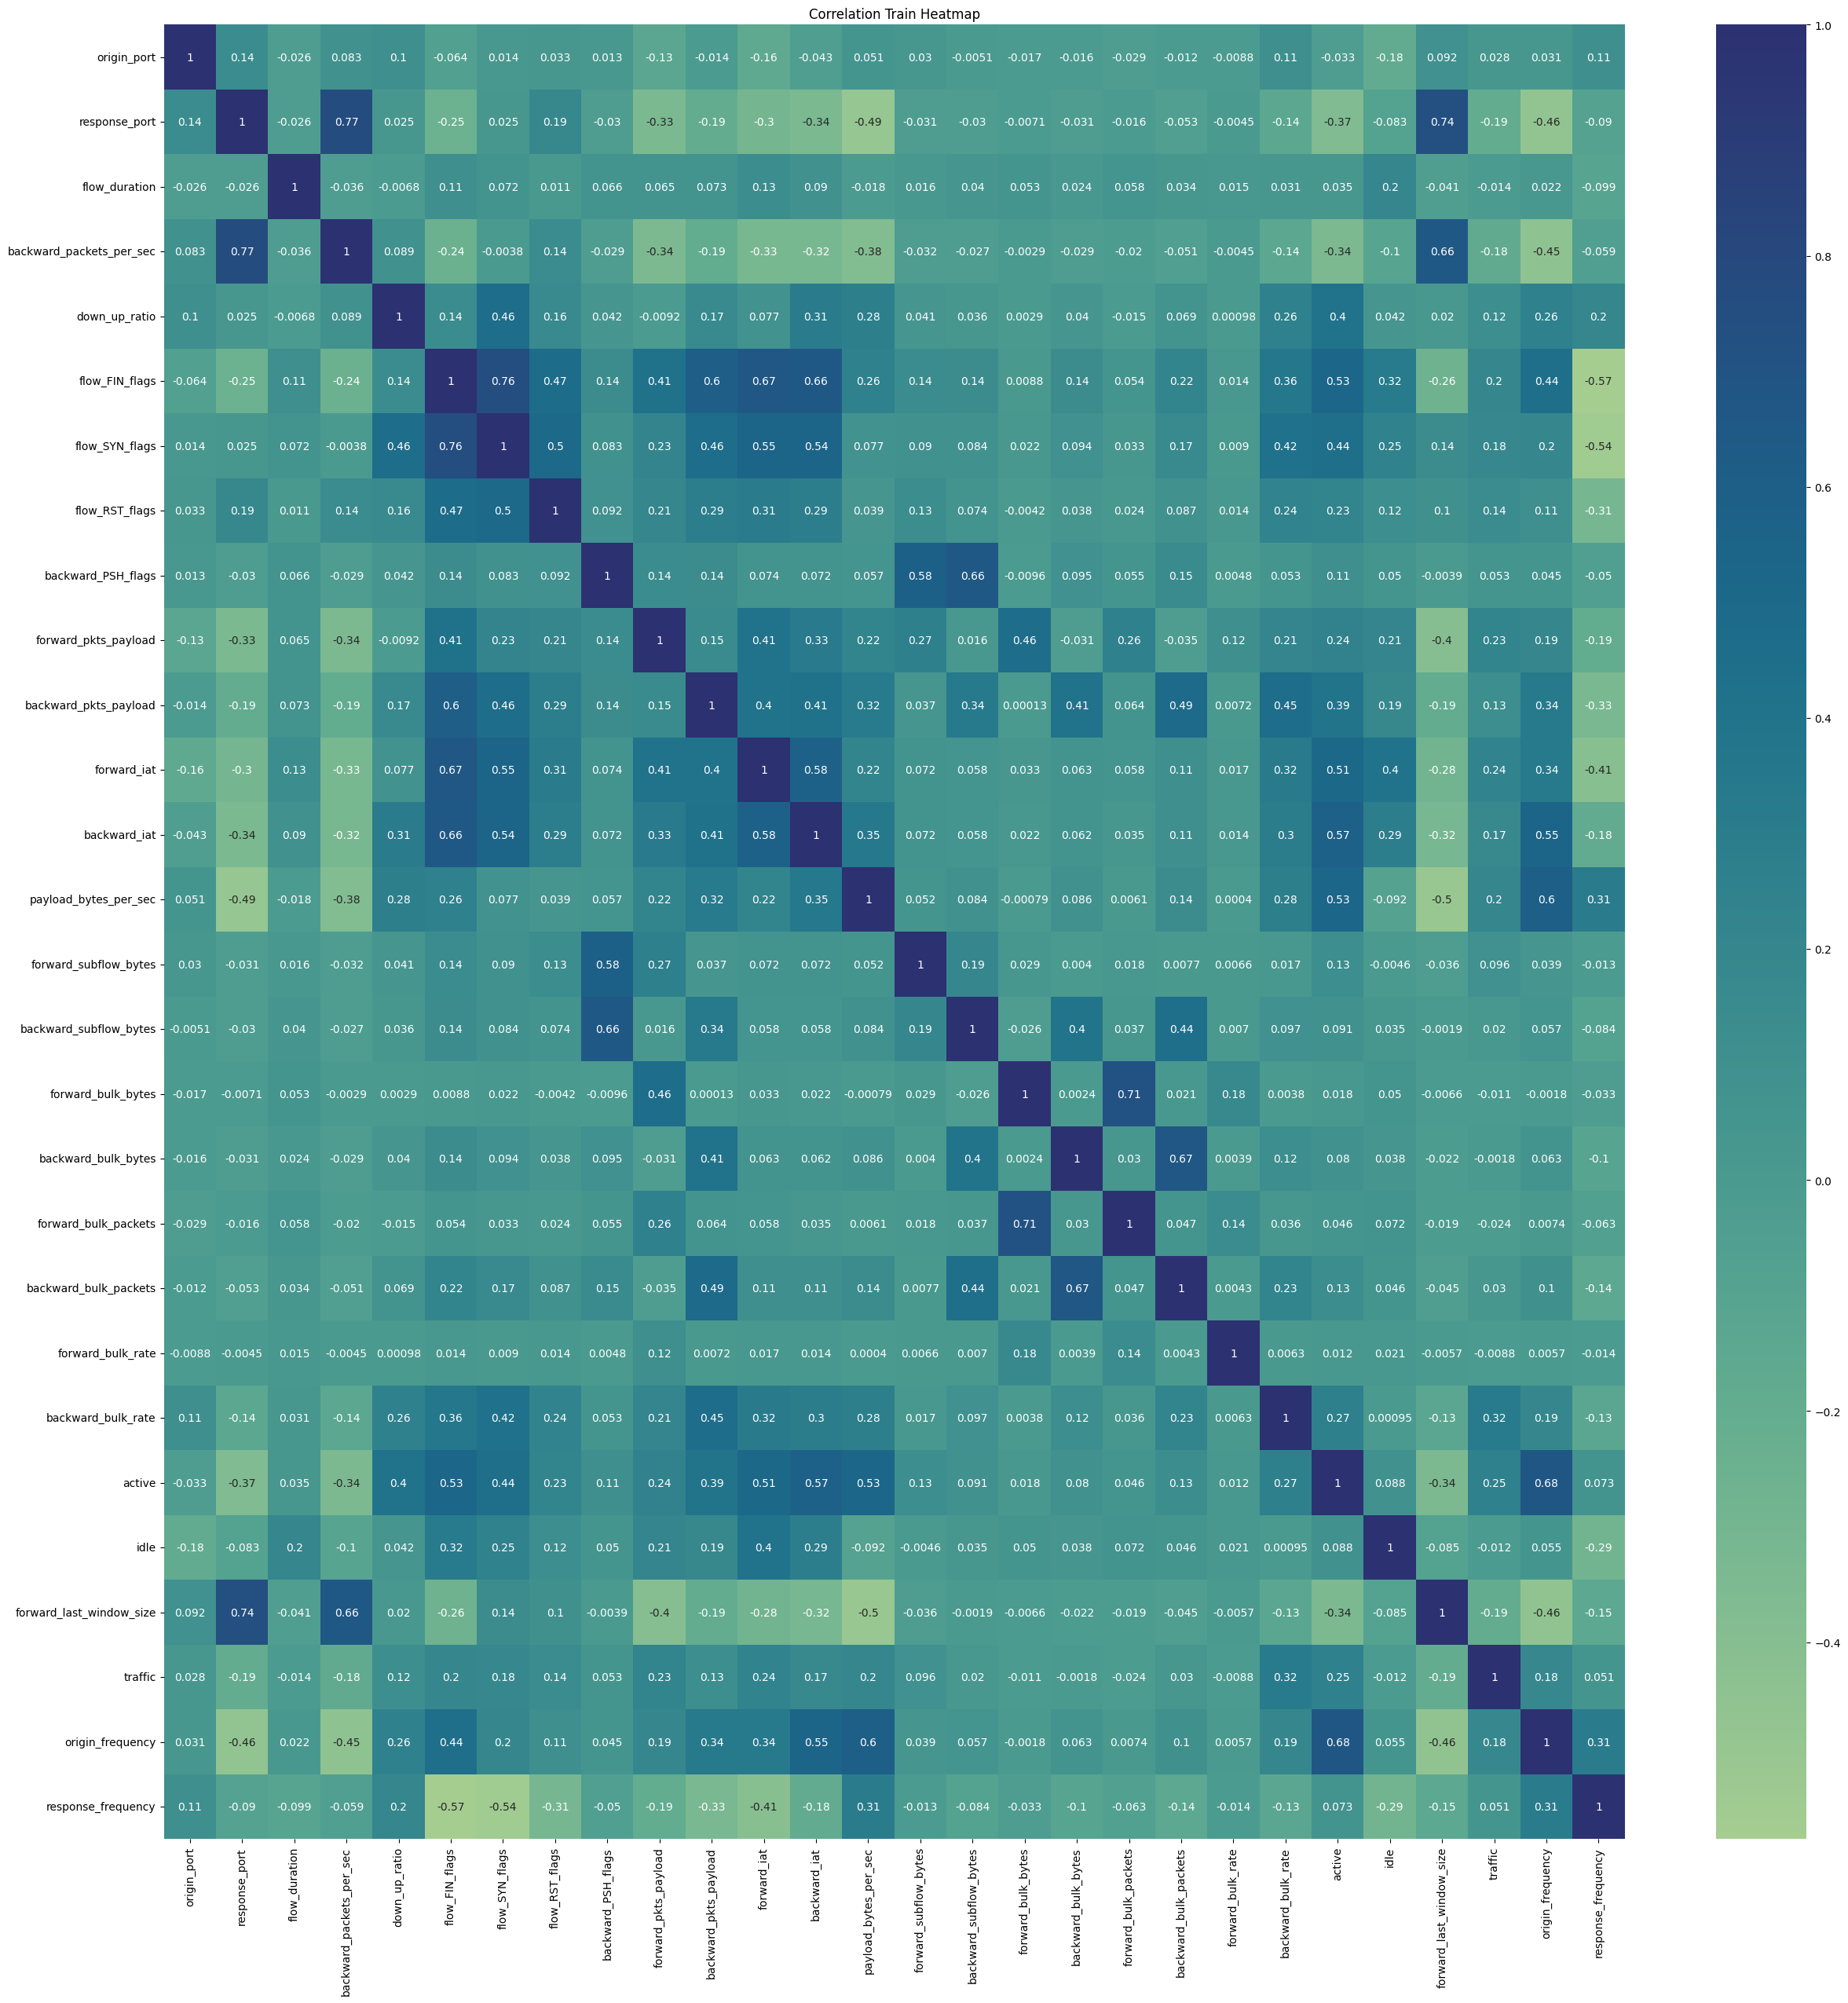

In [ ]:
numeric_df = train_clean.select_dtypes(include=[float, int])
plt.figure(figsize=(30,30))
sns.heatmap(numeric_df.corr(), cmap="crest", annot=True)
plt.title("Correlation Train Heatmap")
plt.show()

In [ ]:
numeric_df.corr()['traffic'].sort_values()

forward_last_window_size   -0.192338
response_port              -0.192275
backward_packets_per_sec   -0.176546
forward_bulk_packets       -0.024164
flow_duration              -0.013964
idle                       -0.012058
forward_bulk_bytes         -0.010540
forward_bulk_rate          -0.008782
backward_bulk_bytes        -0.001847
backward_subflow_bytes      0.020202
origin_port                 0.028455
backward_bulk_packets       0.030137
response_frequency          0.051228
backward_PSH_flags          0.052943
forward_subflow_bytes       0.095535
down_up_ratio               0.123537
backward_pkts_payload       0.127143
flow_RST_flags              0.143193
backward_iat                0.174906
origin_frequency            0.178476
flow_SYN_flags              0.182387
flow_FIN_flags              0.195471
payload_bytes_per_sec       0.203022
forward_pkts_payload        0.233034
forward_iat                 0.237064
active                      0.251557
backward_bulk_rate          0.321988
traffic                     1.000000
Name: traffic, dtype: float64

## Data Cleaning (Test)

In [ ]:
import pandas as pd
from fancyimpute import IterativeImputer as MICE
from sklearn.impute import SimpleImputer

# Inisialisasi MICE imputer
mice_imputer = MICE(random_state=RANDOM_STATE)

# Inisialisasi Robust Imputer
robust_imputer = SimpleImputer(strategy='median')  # Robust terhadap outlier

# Copy dataframe untuk melakukan imputasi
test_clean = test.copy()

# Kolom yang memerlukan imputasi robust
robust_columns = [
    'forward_iat', 'backward_iat', 'flow_iat',
    'payload_bytes_per_sec', 'backward_subflow_bytes', 'backward_bulk_bytes', 'forward_bulk_rate',
    'backward_bulk_rate', 'active', 'idle'
]

# Kolom yang memerlukan imputasi MICE
columns_to_impute = [
    col for col in test_clean.columns if test_clean[col].dtype in ['float64', 'int64']
    and test_clean[col].isnull().any()
    and col not in robust_columns
]

# Imputasi robust
test_clean[robust_columns] = robust_imputer.fit_transform(test_clean[robust_columns])

# Imputasi MICE
test_clean[columns_to_impute] = mice_imputer.fit_transform(test_clean[columns_to_impute])

# Tampilkan hasil untuk memeriksa apakah nilai yang hilang sudah terisi
print(test_clean.isnull().sum())


id                              0
origin_host                     0
origin_port                     0
response_host                   0
response_port                   0
flow_duration                   0
forward_packets_per_sec         0
backward_packets_per_sec        0
flow_packets_per_sec            0
down_up_ratio                   0
flow_FIN_flags                  0
flow_SYN_flags                  0
flow_RST_flags                  0
forward_PSH_flags               0
backward_PSH_flags              0
flow_ACK_flags                  0
forward_URG_flags               0
backward_URG_flags              0
flow_CWR_flags                  0
flow_ECE_flags                  0
forward_pkts_payload            0
backward_pkts_payload           0
flow_pkts_payload               0
forward_iat                     0
backward_iat                    0
flow_iat                        0
payload_bytes_per_sec           0
forward_subflow_packets         0
backward_subflow_packets        0
forward_subflo

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Cetak hasil imputasi
test_clean.to_csv("test_clean_v7.csv",index=False)

In [ ]:
# Test Clean
test_clean = pd.read_csv("/content/test_clean_v7.csv")

In [ ]:
# Frequency Encode
test_clean['origin_frequency'] = test_clean['origin_host'].map(origin_freq)
test_clean['response_frequency'] = test_clean['response_host'].map(response_freq)

# Drop
test_clean = test_clean.copy().drop(['response_host','origin_host','forward_URG_flags', 'backward_URG_flags', 'flow_CWR_flags', 'flow_ECE_flags', 'flow_packets_per_sec', 'flow_ACK_flags', 'flow_pkts_payload', 'flow_iat', 'forward_PSH_flags', 'backward_subflow_packets', 'forward_packets_per_sec', 'forward_initial_window_size', 'forward_subflow_packets', 'backward_initial_window_size'],axis=1)
test_clean

id  origin_port  response_port  flow_duration  \
0       ClDOIi3yLGMfeRPzAc        49188            443       1.738424   
1       C9chsd1cHTOBBHe6Q2         5678           5678       0.000000   
2       CUOe3U1NC5Nln7cItf        32976             53       1.283744   
3       C6QhB04KTRUYOY2rMk        48606            443       8.319324   
4       C60oC51SZNEhCXlX6c        34794            443       0.326490   
...                    ...          ...            ...            ...   
138800  CWXgM92AOvagYVekD3        52975            161      -0.325663   
138801  CMmDuU3aNTnOz4ZwSi        37214          42001       0.000144   
138802  CQO5h64B0lXTYRlsNf        38336             53       0.387097   
138803  CWZZN23jtBV7sZsBLi        37267             53       0.025681   
138804  CAYAeJ26bhNrdT6KVc        50399             53       0.023551   

        backward_packets_per_sec  down_up_ratio  flow_FIN_flags  \
0                       8.085492       0.975862        2.000000   
1                       0.000000       0.000000       -0.104670   
2                     475.773719       1.000000        0.000000   
3                      51.891033       1.133631        1.000000   
4                      39.778075       1.300000        1.000000   
...                          ...            ...             ...   
138800               5552.244307       1.000000        0.047725   
138801               6857.326912       1.000000        0.000000   
138802                 33.424744       1.000000        0.000000   
138803                 77.876828       0.838151        0.000000   
138804                 84.922130       0.616283        0.000000   

        flow_SYN_flags  flow_RST_flags  backward_PSH_flags  ...  \
0             2.115737        0.943146            3.000000  ...   
1             0.000000        0.000000           -7.821882  ...   
2             0.000000        0.000000            0.000000  ...   
3             2.000000        1.000000            7.000000  ...   
4             2.098767        1.000000            7.000000  ...   
...                ...             ...                 ...  ...   
138800        0.094816        0.234368            0.000000  ...   
138801        1.000000        1.000000            0.000000  ...   
138802        0.000000        0.051009            0.000000  ...   
138803        0.100682        0.000000            0.000000  ...   
138804        0.000000        0.000000            0.000000  ...   

        backward_bulk_bytes  forward_bulk_packets  backward_bulk_packets  \
0                       0.0              0.000000               2.708601   
1                       0.0              0.000000              -0.169045   
2                       0.0              0.002837               0.000000   
3                    4585.0              0.000000               5.000000   
4                    4585.0              0.000000               5.192215   
...                     ...                   ...                    ...   
138800                  0.0              0.000000               0.000000   
138801                  0.0             -0.023474               0.000000   
138802                  0.0              0.000000               0.000000   
138803                  0.0              0.000000               0.000000   
138804                  0.0              0.000000               0.000000   

        forward_bulk_rate  backward_bulk_rate        active  idle  \
0                     0.0        0.000000e+00  1.738440e+06   0.0   
1                     0.0        0.000000e+00  0.000000e+00   0.0   
2                     0.0        0.000000e+00  2.486110e+04   0.0   
3                     0.0        1.544649e+07  2.697961e+05   0.0   
4                     0.0        5.211622e+07  2.588487e+04   0.0   
...                   ...                 ...           ...   ...   
138800                0.0        0.000000e+00  1.368523e+02   0.0   
138801                0.0        0.000000e+00  2.588487e+04   0.0   
138

In [ ]:
print(check_dataframe_abnormalities(test_clean))

{}


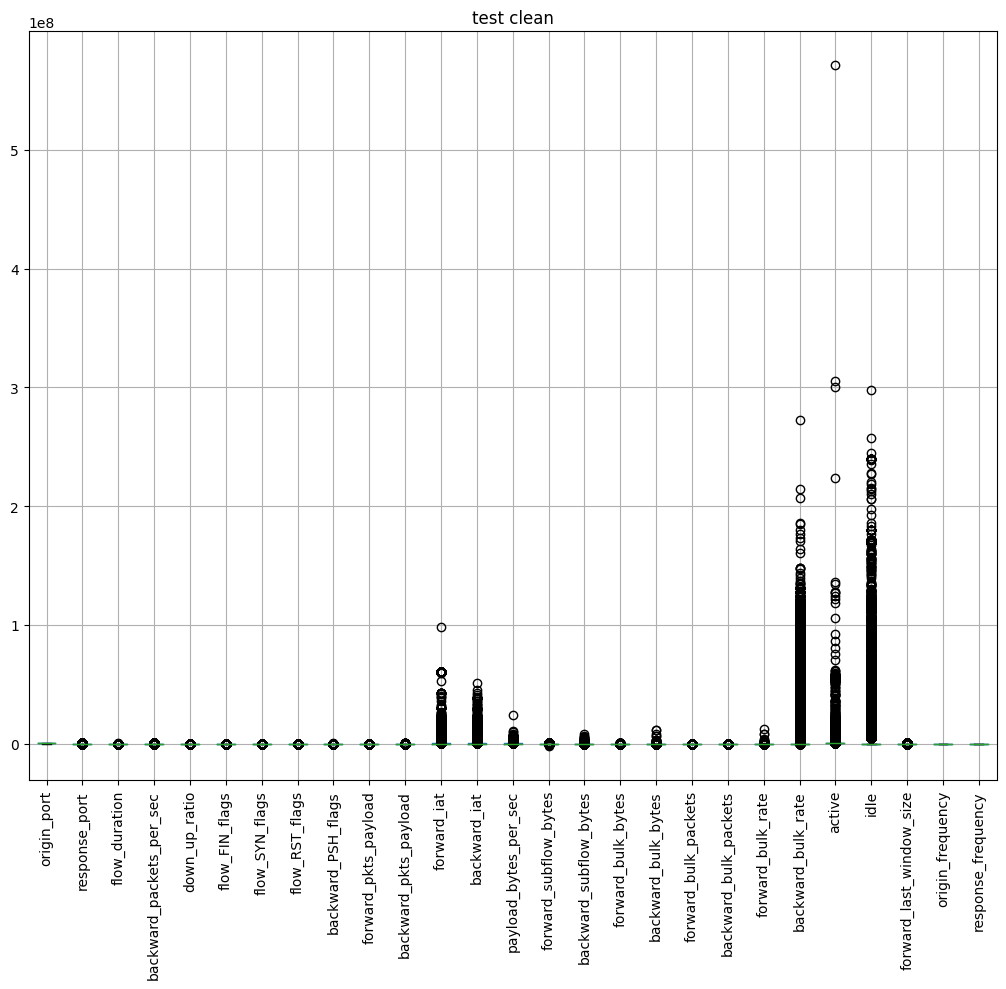

In [ ]:
plt.figure(figsize=(20, 10))

test_clean_copy = test_clean.copy()

# boxplot untuk df_normalized
plt.subplot(1, 2, 1)
# train_clean['Price'] = train_clean['Price_log'].copy()
# train_clean = train_clean.drop(columns=['id'])
test_clean_copy = test_clean_copy.drop(columns=['id'])
test_clean_copy.boxplot()
plt.title('test clean')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

columns_to_log_transform = ['backward_iat', 'forward_iat',
                            'payload_bytes_per_sec',
                            'backward_bulk_rate', 'active', 'idle']

for col in columns_to_log_transform:
    test_clean[col] = np.log1p(test_clean[col])


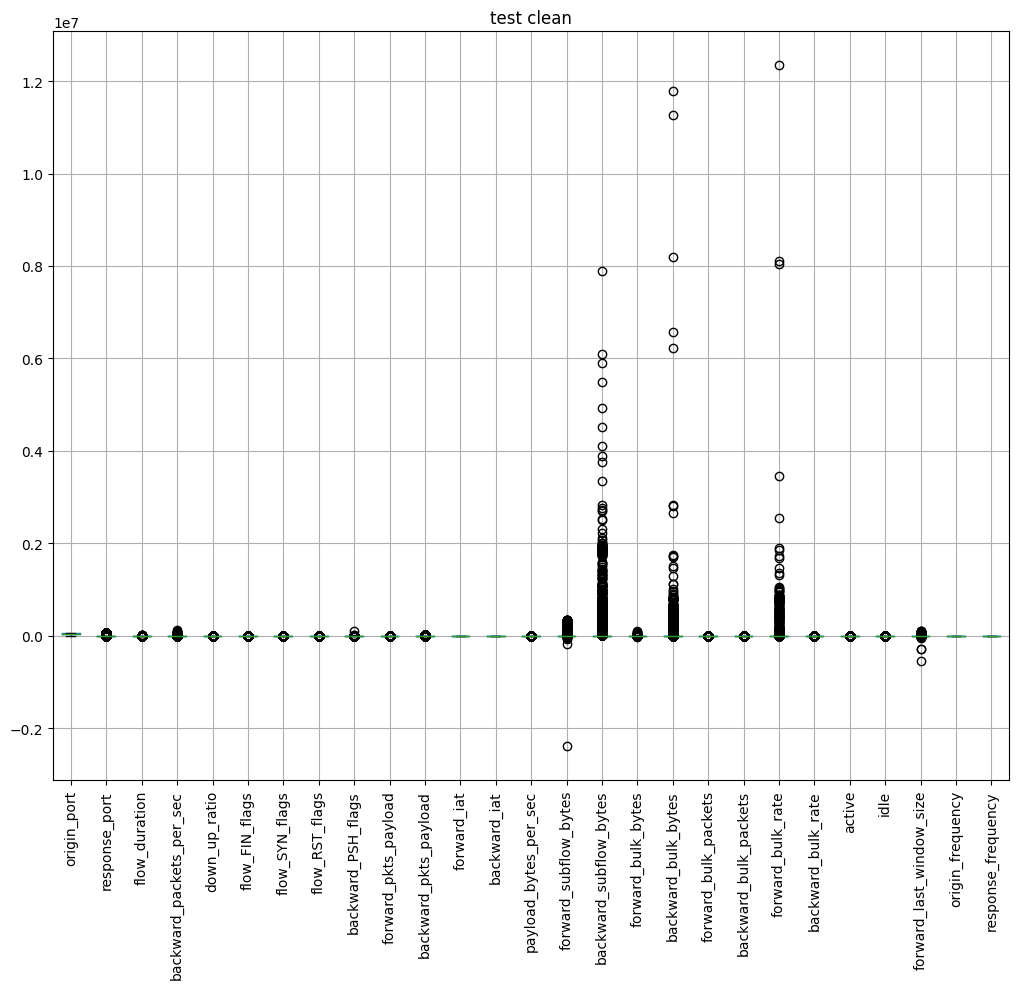

In [ ]:
plt.figure(figsize=(20, 10))

test_clean_copy = test_clean.copy()

# boxplot untuk df_normalized
plt.subplot(1, 2, 1)
# train_clean['Price'] = train_clean['Price_log'].copy()
# train_clean = train_clean.drop(columns=['id'])
test_clean_copy = test_clean_copy.drop(columns=['id'])
test_clean_copy.boxplot()
plt.title('test clean')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [ ]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138805 entries, 0 to 138804
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        138805 non-null  object 
 1   origin_port               138805 non-null  int64  
 2   response_port             138805 non-null  int64  
 3   flow_duration             138805 non-null  float64
 4   backward_packets_per_sec  138805 non-null  float64
 5   down_up_ratio             138805 non-null  float64
 6   flow_FIN_flags            138805 non-null  float64
 7   flow_SYN_flags            138805 non-null  float64
 8   flow_RST_flags            138805 non-null  float64
 9   backward_PSH_flags        138805 non-null  float64
 10  forward_pkts_payload      138805 non-null  float64
 11  backward_pkts_payload     138805 non-null  float64
 12  forward_iat               138805 non-null  float64
 13  backward_iat              138805 non-null  f

In [ ]:
test_clean.describe()

origin_port  response_port  flow_duration  backward_packets_per_sec  \
count  138805.000000  138805.000000  138805.000000             138805.000000   
mean    38643.171716    5026.990533       9.105423               1660.734760   
std     18069.127007   12846.383380      72.972214               4373.023015   
min        21.000000       0.000000   -8949.858733              -5815.128456   
25%     28397.000000      53.000000       0.000139                  5.838373   
50%     42678.000000     443.000000       0.217716                 53.246514   
75%     53066.000000     443.000000       4.088498                294.866942   
max     65535.000000   65476.000000   13544.854760             119647.494428   

       down_up_ratio  flow_FIN_flags  flow_SYN_flags  flow_RST_flags  \
count  138805.000000   138805.000000   138805.000000   138805.000000   
mean        0.884495        0.560586        0.927632        0.504664   
std         0.497319        0.823250        1.012860        0.856178   
min       -11.770397      -23.488117       -9.573923      -13.423687   
25%         0.740968        0.000000        0.000000        0.000000   
50%         1.000000        0.000000        1.000000        0.000000   
75%         1.000000        1.000000        2.000000        1.000000   
max        29.166655       18.648924       23.000000      110.000000   

       backward_PSH_flags  forward_pkts_payload  ...  backward_bulk_bytes  \
count       138805.000000         138805.000000  ...         1.388050e+05   
mean            11.207379             52.684315  ...         4.744994e+03   
std            276.780828             50.274458  ...         6.679434e+04   
min           -927.356085           -558.516944  ...         0.000000e+00   
25%              0.000000             34.000000  ...         0.000000e+00   
50%              0.000000             42.000000  ...         0.000000e+00   
75%              5.837022             78.204625  ...         0.000000e+00   
max          98009.000000           2896.895833  ...         1.178772e+07   

       forward_bulk_packets  backward_bulk_packets  forward_bulk_rate  \
count         138805.000000          138805.000000       1.388050e+05   
mean               0.029948               2.501241       7.831829e+02   
std                0.555009              15.968993       5.077375e+04   
min              -46.009180            -463.914425       0.000000e+00   
25%                0.000000               0.000000       0.000000e+00   
50%                0.000000               0.000000       0.000000e+00   
75%                0.000000               0.879954       0.000000e+00   
max               57.434896            2792.000000       1.233944e+07   

       backward_bulk_rate         active           idle  \
count       138805.000000  138805.000000  138805.000000   
mean             2.038351       9.627285       1.284476   
std              5.369235       3.883715       4.500806   
min              0.000000       0.000000       0.000000   
25%              0.000000      10.108059       0.000000   
50%              0.000000      10.161452       0.000000   
75%              0.000000      12.246071       0.000000   
max             19.421994      20.163299      19.512595   

       forward_last_window_size  origin_frequency  response_frequency  
count             138805.000000     138805.000000       138805.000000  
mean                4528.734453          0.270556            0.182322  
std                10815.299569          0.143628            0.131101  
min              -541386.797253          0.000002            0.000002  
25%                    0.000000          0.103530            0.065783  
50%                   63.258932          0.328900            0.179483  
75%                 1332.101215          0.384528            0.341569  
max               110493.305335          0.384528            0.341569  

[8 rows x 27 columns]

<ipython-input-46-274f8c8c0dd2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_le.classes_, y=class_counts.values, palette='viridis')


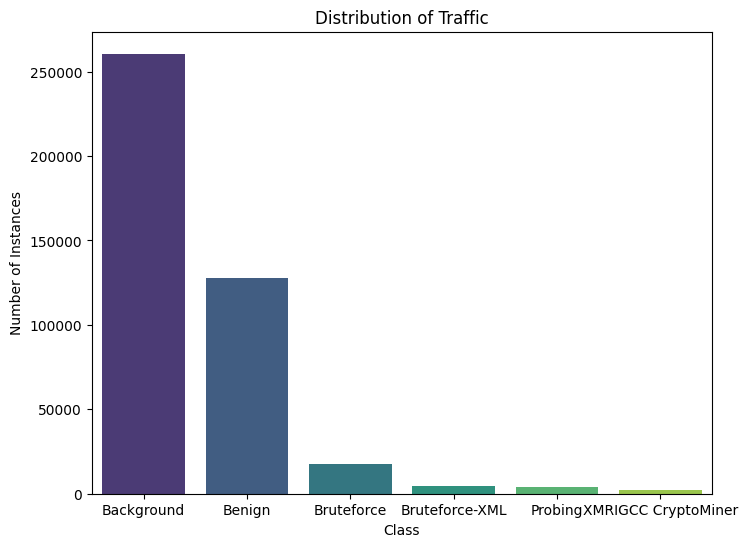

In [ ]:
# Count the occurrences of each class
class_counts = train_clean['traffic'].value_counts()

# Plot the distribution of classes
plt.figure(figsize=(8, 6))
sns.barplot(x=traffic_le.classes_, y=class_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Distribution of Traffic')
plt.show()

# Classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Assuming train_clean is your DataFrame
X = train_clean.drop(['id', 'traffic'], axis=1)
y = train_clean['traffic']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

# Verify class distribution in the training set
class_distribution = y_train.value_counts()
print("Class distribution in training set:\n", class_distribution)

# Find the size of the 'Benign' class (encoded as 1)
benign_count = class_distribution.get(0, 0)

benign_count = int(benign_count * 2 / 3)

# Initialize oversampling and undersampling
os = SMOTE(random_state=RANDOM_STATE)

# Perform undersampling only if 'Background' (encoded as 0) is present
if 0 in class_distribution.index:
    # Undersample 'Background' class to match the size of 'Benign' class
    us = RandomUnderSampler(sampling_strategy={1: benign_count}, random_state=RANDOM_STATE)
    X_train, y_train = us.fit_resample(X_train, y_train)

if 0 in class_distribution.index:
    # Undersample 'Background' class to match the size of 'Benign' class
    us = RandomUnderSampler(sampling_strategy={0: benign_count}, random_state=RANDOM_STATE)
    X_train, y_train = us.fit_resample(X_train, y_train)


# Perform oversampling on the 'Benign' class (encoded as 1)
X_train, y_train = os.fit_resample(X_train, y_train)

# Verify the sizes of train and test sets
print("Train:", len(X_train))
print("Test:", len(X_test))


Class distribution in training set:
 traffic
1    195432
0     95712
4     13157
2      3310
3      2895
5      1848
Name: count, dtype: int64
Train: 382848
Test: 104119


In [ ]:
print(dict(zip(traffic_le.classes_, traffic_le.transform(traffic_le.classes_))))

{'Background': 0, 'Benign': 1, 'Bruteforce': 2, 'Bruteforce-XML': 3, 'Probing': 4, 'XMRIGCC CryptoMiner': 5}


<ipython-input-50-26f2075f94b6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_le.classes_, y=class_counts.values, palette='viridis')


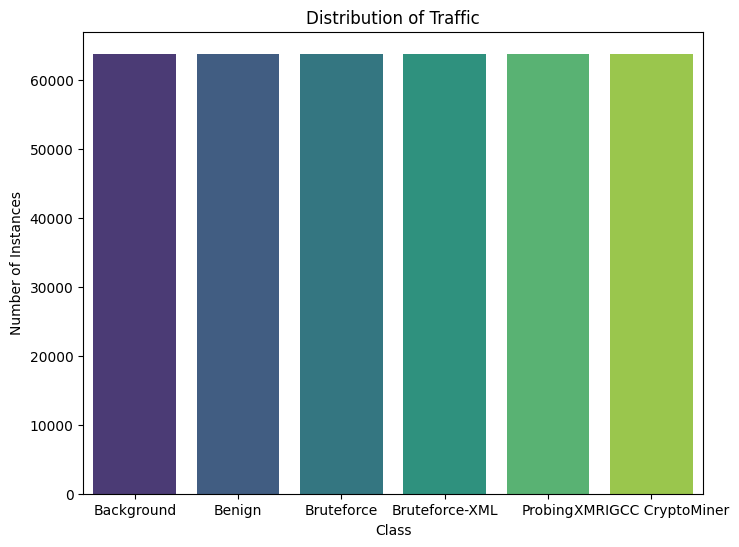

In [ ]:
class_counts = y_train.value_counts()

# Plot the distribution of classes
plt.figure(figsize=(8, 6))
sns.barplot(x=traffic_le.classes_, y=class_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Distribution of Traffic')
plt.show()

## XGBoost MultiClass

In [ ]:
def objective(trial):
    param = {
        'objective': 'multi:softmax',  # Multiclass classification
        'num_class': 6,
        'device': 'cuda',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0,log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0,log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Create DMatrix
    train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

    # Train XGBoost model
    model = xgb.train(param, train_dmatrix, num_boost_round=100)

    # Predict and evaluate
    y_pred = model.predict(xgb.DMatrix(data=X_test, label=y_test))
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    score = (bal_acc+acc)/2
    print(f"Balanced Accuracy Score: {score}")

    return score

# Create a study
study = optuna.create_study(direction='maximize')  # Maximize accuracy

# Optimize the study
study.optimize(objective, n_trials=100)

[I 2024-08-31 00:32:21,418] A new study created in memory with name: no-name-aae4b0b5-2a86-4eb2-ba5d-82745e014b34
[I 2024-08-31 00:32:25,135] Trial 0 finished with value: 0.7988645244696508 and parameters: {'max_depth': 6, 'eta': 7.578994217734382e-07, 'subsample': 0.5641355513781594, 'colsample_bytree': 0.5238356189664142, 'lambda': 0.26916099957757206, 'alpha': 0.000475569416855248, 'min_child_weight': 6}. Best is trial 0 with value: 0.7988645244696508.


Balanced Accuracy Score: 0.7988645244696508


[I 2024-08-31 00:32:30,855] Trial 1 finished with value: 0.8147038286212998 and parameters: {'max_depth': 10, 'eta': 4.9264897650220966e-08, 'subsample': 0.5916873110361964, 'colsample_bytree': 0.5142687846696392, 'lambda': 9.293147195646111e-07, 'alpha': 0.47502814025175427, 'min_child_weight': 9}. Best is trial 1 with value: 0.8147038286212998.


Balanced Accuracy Score: 0.8147038286212998


[I 2024-08-31 00:32:36,804] Trial 2 finished with value: 0.8228783904739461 and parameters: {'max_depth': 9, 'eta': 0.009762941811456443, 'subsample': 0.903180670285836, 'colsample_bytree': 0.5023556572445649, 'lambda': 0.008864953442215618, 'alpha': 1.4935346656847183e-08, 'min_child_weight': 10}. Best is trial 2 with value: 0.8228783904739461.


Balanced Accuracy Score: 0.8228783904739461


[I 2024-08-31 00:32:40,034] Trial 3 finished with value: 0.7894163332168136 and parameters: {'max_depth': 5, 'eta': 1.9179789974559155e-06, 'subsample': 0.9238157437481429, 'colsample_bytree': 0.6890600902180921, 'lambda': 4.727075398991514e-07, 'alpha': 3.061233666965792e-06, 'min_child_weight': 2}. Best is trial 2 with value: 0.8228783904739461.


Balanced Accuracy Score: 0.7894163332168136


[I 2024-08-31 00:32:47,351] Trial 4 finished with value: 0.8290072026014557 and parameters: {'max_depth': 10, 'eta': 9.529509391830945e-06, 'subsample': 0.9499737890789441, 'colsample_bytree': 0.895292302101018, 'lambda': 6.247361966290346e-07, 'alpha': 9.2811376832154e-05, 'min_child_weight': 1}. Best is trial 4 with value: 0.8290072026014557.


Balanced Accuracy Score: 0.8290072026014557


[I 2024-08-31 00:32:52,530] Trial 5 finished with value: 0.8192235544401679 and parameters: {'max_depth': 9, 'eta': 2.1732163858693092e-07, 'subsample': 0.5096424206384875, 'colsample_bytree': 0.7657921747952693, 'lambda': 0.043263125223948304, 'alpha': 4.1888023154304735e-08, 'min_child_weight': 9}. Best is trial 4 with value: 0.8290072026014557.


Balanced Accuracy Score: 0.8192235544401679


[I 2024-08-31 00:32:59,043] Trial 6 finished with value: 0.7911298660003541 and parameters: {'max_depth': 9, 'eta': 1.1576201782039539e-08, 'subsample': 0.8361866138941922, 'colsample_bytree': 0.7435948618848763, 'lambda': 0.005844013465708225, 'alpha': 0.005749158298235896, 'min_child_weight': 5}. Best is trial 4 with value: 0.8290072026014557.


Balanced Accuracy Score: 0.7911298660003541


[I 2024-08-31 00:33:07,147] Trial 7 finished with value: 0.8464072185221625 and parameters: {'max_depth': 10, 'eta': 0.058990087509745145, 'subsample': 0.9812436869094316, 'colsample_bytree': 0.7591924247851908, 'lambda': 1.3716128715288908e-07, 'alpha': 5.764564495244198e-05, 'min_child_weight': 5}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8464072185221625


[I 2024-08-31 00:33:10,691] Trial 8 finished with value: 0.798566765610299 and parameters: {'max_depth': 6, 'eta': 1.7455375837313482e-05, 'subsample': 0.717377890185174, 'colsample_bytree': 0.7012831102357944, 'lambda': 2.946714642286671e-07, 'alpha': 8.39237200825301e-05, 'min_child_weight': 8}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.798566765610299


[I 2024-08-31 00:33:14,476] Trial 9 finished with value: 0.8185787846788931 and parameters: {'max_depth': 7, 'eta': 0.018180052765169295, 'subsample': 0.6871750460910826, 'colsample_bytree': 0.6510577776362882, 'lambda': 0.3889075999120053, 'alpha': 0.03115564852578484, 'min_child_weight': 1}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8185787846788931


[I 2024-08-31 00:33:16,852] Trial 10 finished with value: 0.8395614690066201 and parameters: {'max_depth': 4, 'eta': 0.30125865558912734, 'subsample': 0.8198465763497209, 'colsample_bytree': 0.9406691548125883, 'lambda': 1.2141893907533302e-08, 'alpha': 1.5402548656952791e-06, 'min_child_weight': 4}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8395614690066201


[I 2024-08-31 00:33:18,893] Trial 11 finished with value: 0.832785836785279 and parameters: {'max_depth': 3, 'eta': 0.8734785150798052, 'subsample': 0.8211501860679108, 'colsample_bytree': 0.9689348016478144, 'lambda': 1.0872569726728215e-08, 'alpha': 1.4466353101715206e-06, 'min_child_weight': 4}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.832785836785279


[I 2024-08-31 00:33:20,921] Trial 12 finished with value: 0.8348001914577223 and parameters: {'max_depth': 3, 'eta': 0.8795547103456763, 'subsample': 0.9755233086415604, 'colsample_bytree': 0.8658101550516015, 'lambda': 1.0076008399694833e-08, 'alpha': 1.5934309260139293e-06, 'min_child_weight': 4}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8348001914577223


[I 2024-08-31 00:33:23,320] Trial 13 finished with value: 0.7785310803514935 and parameters: {'max_depth': 4, 'eta': 0.0021147123528302983, 'subsample': 0.8151130879139609, 'colsample_bytree': 0.9972438962734064, 'lambda': 3.410964057643581e-05, 'alpha': 4.335515048299849e-06, 'min_child_weight': 6}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.7785310803514935


[I 2024-08-31 00:33:27,731] Trial 14 finished with value: 0.8061433044600597 and parameters: {'max_depth': 7, 'eta': 0.0006152874747218018, 'subsample': 0.875806969827608, 'colsample_bytree': 0.8388920616788178, 'lambda': 3.3544618217740126e-05, 'alpha': 1.5753818385416573e-07, 'min_child_weight': 3}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8061433044600597


[I 2024-08-31 00:33:32,868] Trial 15 finished with value: 0.846194933925331 and parameters: {'max_depth': 8, 'eta': 0.0823094892058938, 'subsample': 0.7610370768184703, 'colsample_bytree': 0.6100185385088374, 'lambda': 1.0165380540653673e-07, 'alpha': 3.3485205442815146e-05, 'min_child_weight': 7}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.846194933925331


[I 2024-08-31 00:33:37,568] Trial 16 finished with value: 0.8406123664139606 and parameters: {'max_depth': 8, 'eta': 0.04940120252251702, 'subsample': 0.6350457490213798, 'colsample_bytree': 0.6108135060327633, 'lambda': 6.447788173486802e-06, 'alpha': 0.00038822217206063914, 'min_child_weight': 7}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8406123664139606


[I 2024-08-31 00:33:42,333] Trial 17 finished with value: 0.8104385725075997 and parameters: {'max_depth': 8, 'eta': 0.00024981610231117053, 'subsample': 0.7292209693298828, 'colsample_bytree': 0.5894797644055862, 'lambda': 0.0005767232819834569, 'alpha': 2.3109702464882116e-05, 'min_child_weight': 7}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8104385725075997


[I 2024-08-31 00:33:47,255] Trial 18 finished with value: 0.8418396826560222 and parameters: {'max_depth': 8, 'eta': 0.05791696995054294, 'subsample': 0.9885673606420203, 'colsample_bytree': 0.7866078727865439, 'lambda': 9.745533696550601e-08, 'alpha': 0.003968333165936726, 'min_child_weight': 7}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8418396826560222


[I 2024-08-31 00:33:53,913] Trial 19 finished with value: 0.8307853286170204 and parameters: {'max_depth': 10, 'eta': 0.0036901436641522943, 'subsample': 0.773386542972627, 'colsample_bytree': 0.8191903474413343, 'lambda': 7.202398589846792e-08, 'alpha': 0.0017449436897923588, 'min_child_weight': 5}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8307853286170204


[I 2024-08-31 00:33:59,038] Trial 20 finished with value: 0.8462276599269121 and parameters: {'max_depth': 9, 'eta': 0.1140942321948103, 'subsample': 0.6567305271841518, 'colsample_bytree': 0.5724763534107338, 'lambda': 4.183455377793966e-06, 'alpha': 0.03830983822480871, 'min_child_weight': 8}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8462276599269121


[I 2024-08-31 00:34:04,018] Trial 21 finished with value: 0.8446409033125432 and parameters: {'max_depth': 9, 'eta': 0.1432558128216655, 'subsample': 0.6659142289200549, 'colsample_bytree': 0.5701508978172541, 'lambda': 4.369135863766646e-06, 'alpha': 0.10019265910594867, 'min_child_weight': 9}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8446409033125432


[I 2024-08-31 00:34:09,378] Trial 22 finished with value: 0.8254091366437183 and parameters: {'max_depth': 8, 'eta': 0.018341786159804654, 'subsample': 0.6063418390725671, 'colsample_bytree': 0.6473941975125426, 'lambda': 3.469355040515459e-06, 'alpha': 1.6547678623066252e-05, 'min_child_weight': 8}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8254091366437183


[I 2024-08-31 00:34:17,051] Trial 23 finished with value: 0.8249071675078783 and parameters: {'max_depth': 10, 'eta': 0.0010550409904178854, 'subsample': 0.5382166346299843, 'colsample_bytree': 0.7161666020068891, 'lambda': 7.667890756061447e-08, 'alpha': 0.00039878034314574657, 'min_child_weight': 8}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8249071675078783


[I 2024-08-31 00:34:22,616] Trial 24 finished with value: 0.8179524685288895 and parameters: {'max_depth': 9, 'eta': 6.722375576260772e-05, 'subsample': 0.7547046442222631, 'colsample_bytree': 0.6391720148230625, 'lambda': 9.312759422687087e-05, 'alpha': 0.022710468779317868, 'min_child_weight': 6}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8179524685288895


[I 2024-08-31 00:34:26,358] Trial 25 finished with value: 0.8436458258903279 and parameters: {'max_depth': 7, 'eta': 0.1502724276011929, 'subsample': 0.6621166712112719, 'colsample_bytree': 0.5588987165160187, 'lambda': 2.431920058928679e-06, 'alpha': 1.9780625960028847e-05, 'min_child_weight': 7}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8436458258903279


[I 2024-08-31 00:34:32,236] Trial 26 finished with value: 0.8453144697970574 and parameters: {'max_depth': 10, 'eta': 0.050499228582616795, 'subsample': 0.7766965307449264, 'colsample_bytree': 0.6762257226025825, 'lambda': 9.91001159904123e-08, 'alpha': 0.8035751219966043, 'min_child_weight': 10}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8453144697970574


[I 2024-08-31 00:34:37,645] Trial 27 finished with value: 0.8165899544407523 and parameters: {'max_depth': 8, 'eta': 0.006556728955087663, 'subsample': 0.8713742053589874, 'colsample_bytree': 0.5490245801046981, 'lambda': 1.845207319833513e-05, 'alpha': 7.693604650305394e-05, 'min_child_weight': 5}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8165899544407523


[I 2024-08-31 00:34:42,383] Trial 28 finished with value: 0.8400752595882858 and parameters: {'max_depth': 9, 'eta': 0.2657346125082625, 'subsample': 0.628777106162795, 'colsample_bytree': 0.6081699123277645, 'lambda': 0.00032987299981136883, 'alpha': 2.596506374472375e-07, 'min_child_weight': 8}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8400752595882858


[I 2024-08-31 00:34:45,337] Trial 29 finished with value: 0.7987584697207101 and parameters: {'max_depth': 6, 'eta': 0.0001273947941613083, 'subsample': 0.7051255303430631, 'colsample_bytree': 0.7314729758806512, 'lambda': 3.8239407453217747e-08, 'alpha': 0.00106346582086672, 'min_child_weight': 6}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.7987584697207101


[I 2024-08-31 00:34:50,819] Trial 30 finished with value: 0.8314312642136865 and parameters: {'max_depth': 8, 'eta': 0.029682174144629432, 'subsample': 0.5762403561558305, 'colsample_bytree': 0.7698685295787296, 'lambda': 1.2893830285520363e-06, 'alpha': 0.00046098706196038663, 'min_child_weight': 3}. Best is trial 7 with value: 0.8464072185221625.


Balanced Accuracy Score: 0.8314312642136865


[I 2024-08-31 00:34:56,605] Trial 31 finished with value: 0.8474285766102548 and parameters: {'max_depth': 10, 'eta': 0.07578734225426448, 'subsample': 0.784028126923972, 'colsample_bytree': 0.6479850407400976, 'lambda': 2.9331608717017615e-07, 'alpha': 0.9221483167497937, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8474285766102548


[I 2024-08-31 00:35:01,959] Trial 32 finished with value: 0.8457486383118415 and parameters: {'max_depth': 10, 'eta': 0.1301586312407954, 'subsample': 0.790747045276712, 'colsample_bytree': 0.5295979648823002, 'lambda': 2.7894737559659643e-07, 'alpha': 0.15598680852966637, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8457486383118415


[I 2024-08-31 00:35:07,202] Trial 33 finished with value: 0.8367013849891907 and parameters: {'max_depth': 9, 'eta': 0.42787943593901395, 'subsample': 0.7377380230214, 'colsample_bytree': 0.6052364324757854, 'lambda': 9.181684236270942e-06, 'alpha': 0.22280820455424952, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8367013849891907


[I 2024-08-31 00:35:13,606] Trial 34 finished with value: 0.8296838022288351 and parameters: {'max_depth': 10, 'eta': 0.007136575529353347, 'subsample': 0.8746851254124538, 'colsample_bytree': 0.633095523306646, 'lambda': 1.5147970408517288e-07, 'alpha': 0.05437246687766951, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8296838022288351


[I 2024-08-31 00:35:18,733] Trial 35 finished with value: 0.8468732875285625 and parameters: {'max_depth': 9, 'eta': 0.0833598497166705, 'subsample': 0.9227740324768345, 'colsample_bytree': 0.6649178536680703, 'lambda': 1.1213392805782145e-06, 'alpha': 0.012561911604540387, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8468732875285625


[I 2024-08-31 00:35:24,588] Trial 36 finished with value: 0.8279674496521092 and parameters: {'max_depth': 9, 'eta': 0.013740234086831284, 'subsample': 0.9661296590153576, 'colsample_bytree': 0.6702226068759205, 'lambda': 8.679552549932109e-07, 'alpha': 0.008896759908822044, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8279674496521092


[I 2024-08-31 00:35:30,539] Trial 37 finished with value: 0.8286558901433152 and parameters: {'max_depth': 10, 'eta': 0.0027777982632388163, 'subsample': 0.9253296193104503, 'colsample_bytree': 0.8062296050968016, 'lambda': 7.65861967517678e-07, 'alpha': 0.3899784020454421, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8286558901433152


[I 2024-08-31 00:35:35,060] Trial 38 finished with value: 0.8223000587078955 and parameters: {'max_depth': 9, 'eta': 0.9914761974496169, 'subsample': 0.9135446102835645, 'colsample_bytree': 0.7132811302719223, 'lambda': 1.4686109776217952e-06, 'alpha': 0.014588980091542837, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8223000587078955


[I 2024-08-31 00:35:41,388] Trial 39 finished with value: 0.8171086435969761 and parameters: {'max_depth': 10, 'eta': 7.356637997633037e-07, 'subsample': 0.9999906677348795, 'colsample_bytree': 0.5152639440721167, 'lambda': 3.964798017105285e-07, 'alpha': 0.9025827922510006, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8171086435969761


[I 2024-08-31 00:35:46,393] Trial 40 finished with value: 0.8344904109697215 and parameters: {'max_depth': 9, 'eta': 0.02662267361390989, 'subsample': 0.9406558469325005, 'colsample_bytree': 0.6846915383934401, 'lambda': 9.782061725983857e-06, 'alpha': 0.06738646609526566, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8344904109697215


[I 2024-08-31 00:35:53,671] Trial 41 finished with value: 0.8473513599924658 and parameters: {'max_depth': 10, 'eta': 0.08082727299159403, 'subsample': 0.851895577952064, 'colsample_bytree': 0.5804353233521333, 'lambda': 3.1523263786228586e-08, 'alpha': 0.00012571661010429703, 'min_child_weight': 8}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8473513599924658


[I 2024-08-31 00:35:59,578] Trial 42 finished with value: 0.8423245883871875 and parameters: {'max_depth': 10, 'eta': 0.2267045443443451, 'subsample': 0.8553862791970653, 'colsample_bytree': 0.5770633667629975, 'lambda': 3.1502115716285524e-08, 'alpha': 0.001984835443638725, 'min_child_weight': 8}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8423245883871875


[I 2024-08-31 00:36:04,977] Trial 43 finished with value: 0.8389053212369783 and parameters: {'max_depth': 10, 'eta': 0.3756247946030808, 'subsample': 0.892334455482402, 'colsample_bytree': 0.5412428164186461, 'lambda': 2.743268959576995e-07, 'alpha': 0.28038422333383706, 'min_child_weight': 5}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8389053212369783


[I 2024-08-31 00:36:12,193] Trial 44 finished with value: 0.8267162811414686 and parameters: {'max_depth': 9, 'eta': 0.009909191310532995, 'subsample': 0.84727591305626, 'colsample_bytree': 0.7505008143538562, 'lambda': 2.640185567689855e-08, 'alpha': 7.526855529430104e-06, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8267162811414686


[I 2024-08-31 00:36:18,536] Trial 45 finished with value: 0.8468875800145201 and parameters: {'max_depth': 9, 'eta': 0.06884174445071678, 'subsample': 0.949500690128095, 'colsample_bytree': 0.5039208398278047, 'lambda': 2.742167309160908e-08, 'alpha': 0.0046015977348670785, 'min_child_weight': 6}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8468875800145201


[I 2024-08-31 00:36:21,484] Trial 46 finished with value: 0.8067606702088754 and parameters: {'max_depth': 5, 'eta': 0.03080172595942359, 'subsample': 0.9502575314388594, 'colsample_bytree': 0.5118998445049128, 'lambda': 2.7673215692877915e-08, 'alpha': 0.00015784085777277018, 'min_child_weight': 6}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8067606702088754


[I 2024-08-31 00:36:28,861] Trial 47 finished with value: 0.8221427007118292 and parameters: {'max_depth': 10, 'eta': 5.330407896291552e-08, 'subsample': 0.8970171958172126, 'colsample_bytree': 0.6269911350263774, 'lambda': 2.0576008241657937e-07, 'alpha': 0.0035464792324907232, 'min_child_weight': 3}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8221427007118292


[I 2024-08-31 00:36:36,295] Trial 48 finished with value: 0.8252009554349973 and parameters: {'max_depth': 10, 'eta': 0.0008542784623315892, 'subsample': 0.9620749257034883, 'colsample_bytree': 0.6564863030800703, 'lambda': 1.6042795492990643e-08, 'alpha': 0.0001539712294557865, 'min_child_weight': 4}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8252009554349973


[I 2024-08-31 00:36:39,709] Trial 49 finished with value: 0.8055571620513391 and parameters: {'max_depth': 7, 'eta': 9.0189477757795e-06, 'subsample': 0.9240378979613129, 'colsample_bytree': 0.6943375538023021, 'lambda': 0.19148628776149582, 'alpha': 0.0007316734979329799, 'min_child_weight': 5}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8055571620513391


[I 2024-08-31 00:36:47,896] Trial 50 finished with value: 0.8230829142272557 and parameters: {'max_depth': 10, 'eta': 0.004644601156993375, 'subsample': 0.8283894779704088, 'colsample_bytree': 0.5007533361814095, 'lambda': 5.160645257832403e-08, 'alpha': 5.5066449419743314e-05, 'min_child_weight': 6}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8230829142272557


[I 2024-08-31 00:36:52,726] Trial 51 finished with value: 0.8468659347543743 and parameters: {'max_depth': 9, 'eta': 0.09002394753814599, 'subsample': 0.8025914830514747, 'colsample_bytree': 0.5334977642339521, 'lambda': 5.23605831276097e-07, 'alpha': 0.03050247284020829, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8468659347543743


[I 2024-08-31 00:36:57,311] Trial 52 finished with value: 0.835755176496884 and parameters: {'max_depth': 9, 'eta': 0.5042980134083351, 'subsample': 0.7987304878946726, 'colsample_bytree': 0.5417483031854654, 'lambda': 5.693893142581818e-07, 'alpha': 0.008906084964658905, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.835755176496884


[I 2024-08-31 00:37:03,449] Trial 53 finished with value: 0.847229043186087 and parameters: {'max_depth': 9, 'eta': 0.07546318466502151, 'subsample': 0.9395819020211176, 'colsample_bytree': 0.5879915424473906, 'lambda': 1.84754039396441e-07, 'alpha': 0.00024887099323010216, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.847229043186087


[I 2024-08-31 00:37:07,697] Trial 54 finished with value: 0.8422424069117371 and parameters: {'max_depth': 8, 'eta': 0.05647230986367516, 'subsample': 0.8050457245152655, 'colsample_bytree': 0.5948441743997237, 'lambda': 1.8330352757053138e-06, 'alpha': 0.018306402666246068, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8422424069117371


[I 2024-08-31 00:37:12,879] Trial 55 finished with value: 0.8468459911925652 and parameters: {'max_depth': 9, 'eta': 0.09465530704359144, 'subsample': 0.9393072193567676, 'colsample_bytree': 0.5279088009188376, 'lambda': 1.8204146705960684e-08, 'alpha': 0.0035167236923163946, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8468459911925652


[I 2024-08-31 00:37:19,197] Trial 56 finished with value: 0.8279767083089822 and parameters: {'max_depth': 9, 'eta': 0.016429119643064247, 'subsample': 0.8535735332257575, 'colsample_bytree': 0.5619570311060931, 'lambda': 0.0024479904358005625, 'alpha': 0.00015439932773521665, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8279767083089822


[I 2024-08-31 00:37:24,501] Trial 57 finished with value: 0.8191742114515819 and parameters: {'max_depth': 9, 'eta': 0.00183838162470133, 'subsample': 0.8893716647008979, 'colsample_bytree': 0.62262375239019, 'lambda': 1.933082795086975e-07, 'alpha': 0.0013179409406568355, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8191742114515819


[I 2024-08-31 00:37:28,542] Trial 58 finished with value: 0.8430541592993714 and parameters: {'max_depth': 8, 'eta': 0.21155040609237935, 'subsample': 0.913103860088874, 'colsample_bytree': 0.5826225338057673, 'lambda': 4.5582356304156763e-07, 'alpha': 0.006551180496547127, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8430541592993714


[I 2024-08-31 00:37:33,616] Trial 59 finished with value: 0.8336330852874272 and parameters: {'max_depth': 9, 'eta': 0.5895532416643872, 'subsample': 0.8360545126855424, 'colsample_bytree': 0.6610056482123415, 'lambda': 4.6168389242203236e-08, 'alpha': 0.1594179063941862, 'min_child_weight': 8}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8336330852874272


[I 2024-08-31 00:37:41,416] Trial 60 finished with value: 0.8421271392622383 and parameters: {'max_depth': 10, 'eta': 0.033633423955455426, 'subsample': 0.7769910478541663, 'colsample_bytree': 0.5542997490185592, 'lambda': 1.0725264849201383e-08, 'alpha': 0.00029160080099262524, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8421271392622383


[I 2024-08-31 00:37:46,500] Trial 61 finished with value: 0.8463860991735417 and parameters: {'max_depth': 9, 'eta': 0.11285709388496767, 'subsample': 0.9410164426351614, 'colsample_bytree': 0.5288274688451051, 'lambda': 1.9728323699352796e-08, 'alpha': 0.0029163704998836936, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8463860991735417


[I 2024-08-31 00:37:51,625] Trial 62 finished with value: 0.8440096144987215 and parameters: {'max_depth': 8, 'eta': 0.06730808160209187, 'subsample': 0.9514619448378736, 'colsample_bytree': 0.5280169251315711, 'lambda': 7.230807931117252e-08, 'alpha': 0.0007770109234689417, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8440096144987215


[I 2024-08-31 00:37:56,678] Trial 63 finished with value: 0.8463989821477138 and parameters: {'max_depth': 9, 'eta': 0.08768159131475818, 'subsample': 0.9786599195738968, 'colsample_bytree': 0.5892004564496667, 'lambda': 1.4480949349797305e-07, 'alpha': 0.0125934621608617, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8463989821477138


[I 2024-08-31 00:38:01,309] Trial 64 finished with value: 0.845581991307746 and parameters: {'max_depth': 9, 'eta': 0.17882302874615882, 'subsample': 0.8786091870167289, 'colsample_bytree': 0.5030888352419665, 'lambda': 4.963321687275722e-08, 'alpha': 0.03312407956024313, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.845581991307746


[I 2024-08-31 00:38:06,475] Trial 65 finished with value: 0.8202708180663929 and parameters: {'max_depth': 8, 'eta': 0.011583089530197228, 'subsample': 0.9345238200541125, 'colsample_bytree': 0.5647637565916602, 'lambda': 1.5046634945252692e-08, 'alpha': 0.004197300248420316, 'min_child_weight': 9}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8202708180663929


[I 2024-08-31 00:38:12,803] Trial 66 finished with value: 0.8436317198559968 and parameters: {'max_depth': 10, 'eta': 0.0396012100947682, 'subsample': 0.9162735480869111, 'colsample_bytree': 0.5422799654881331, 'lambda': 1.2346353368919225e-07, 'alpha': 0.08564091883116864, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8436317198559968


[I 2024-08-31 00:38:16,680] Trial 67 finished with value: 0.8197532202917592 and parameters: {'max_depth': 7, 'eta': 0.02233953494180151, 'subsample': 0.9898531112308704, 'colsample_bytree': 0.5205564159361907, 'lambda': 3.449933260411043e-07, 'alpha': 0.001823762348365966, 'min_child_weight': 8}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8197532202917592


[I 2024-08-31 00:38:23,087] Trial 68 finished with value: 0.8468330875720185 and parameters: {'max_depth': 9, 'eta': 0.0839644065006636, 'subsample': 0.8145377401011802, 'colsample_bytree': 0.5978714486552491, 'lambda': 8.939172312877131e-08, 'alpha': 0.0002417258585567159, 'min_child_weight': 7}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8468330875720185


[I 2024-08-31 00:38:29,204] Trial 69 finished with value: 0.8121126572339379 and parameters: {'max_depth': 8, 'eta': 0.0003797487748627548, 'subsample': 0.9653287754221362, 'colsample_bytree': 0.6215173901928402, 'lambda': 9.129014858250865e-07, 'alpha': 1.2624002811525862e-08, 'min_child_weight': 10}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8121126572339379


[I 2024-08-31 00:38:35,336] Trial 70 finished with value: 0.8393996408111174 and parameters: {'max_depth': 10, 'eta': 0.2888695053379652, 'subsample': 0.8631059985270191, 'colsample_bytree': 0.907225904908208, 'lambda': 2.412068307201315e-08, 'alpha': 0.006638254778297537, 'min_child_weight': 2}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8393996408111174


[I 2024-08-31 00:38:41,145] Trial 71 finished with value: 0.8461967030727306 and parameters: {'max_depth': 9, 'eta': 0.10135048988491203, 'subsample': 0.8139041066077835, 'colsample_bytree': 0.6042046121942652, 'lambda': 6.230235218967175e-08, 'alpha': 4.1948018636980474e-05, 'min_child_weight': 7}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8461967030727306


[I 2024-08-31 00:38:47,424] Trial 72 finished with value: 0.8456628275325909 and parameters: {'max_depth': 9, 'eta': 0.061509763504235974, 'subsample': 0.7663270494847378, 'colsample_bytree': 0.5764082259362621, 'lambda': 9.657971859581238e-08, 'alpha': 0.00026438419397072, 'min_child_weight': 7}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8456628275325909


[I 2024-08-31 00:38:52,560] Trial 73 finished with value: 0.8443266114811365 and parameters: {'max_depth': 9, 'eta': 0.17437667916028396, 'subsample': 0.7401563948729704, 'colsample_bytree': 0.5956134850947932, 'lambda': 1.9594025999921023e-07, 'alpha': 1.0950926638615495e-05, 'min_child_weight': 8}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8443266114811365


[I 2024-08-31 00:38:57,238] Trial 74 finished with value: 0.8304130294849237 and parameters: {'max_depth': 9, 'eta': 0.6678513172983425, 'subsample': 0.7905253266668001, 'colsample_bytree': 0.6426541517152998, 'lambda': 4.868957712425352e-07, 'alpha': 0.025022491341540967, 'min_child_weight': 7}. Best is trial 31 with value: 0.8474285766102548.


Balanced Accuracy Score: 0.8304130294849237


[I 2024-08-31 00:39:04,250] Trial 75 finished with value: 0.8476085293602761 and parameters: {'max_depth': 10, 'eta': 0.07962527564783255, 'subsample': 0.8408871192599532, 'colsample_bytree': 0.5416508763453478, 'lambda': 2.6476813930099973e-06, 'alpha': 0.0009187120955269784, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8476085293602761


[I 2024-08-31 00:39:11,143] Trial 76 finished with value: 0.8260012099658409 and parameters: {'max_depth': 10, 'eta': 0.006672852745600206, 'subsample': 0.9019617211715547, 'colsample_bytree': 0.5479542148105578, 'lambda': 2.1184686101895295e-06, 'alpha': 0.0008788507864394509, 'min_child_weight': 9}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8260012099658409


[I 2024-08-31 00:39:18,615] Trial 77 finished with value: 0.843644960431612 and parameters: {'max_depth': 10, 'eta': 0.03906572075472222, 'subsample': 0.8312043913244275, 'colsample_bytree': 0.5339558311746745, 'lambda': 3.302550320364103e-06, 'alpha': 0.000649201244946584, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.843644960431612


[I 2024-08-31 00:39:23,820] Trial 78 finished with value: 0.8423642503709816 and parameters: {'max_depth': 10, 'eta': 0.3291667818985982, 'subsample': 0.8861618230436137, 'colsample_bytree': 0.5137900242803314, 'lambda': 9.947495050811176e-05, 'alpha': 0.002737467887398568, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8423642503709816


[I 2024-08-31 00:39:30,333] Trial 79 finished with value: 0.8355660424999705 and parameters: {'max_depth': 10, 'eta': 0.021039079753001327, 'subsample': 0.7855301620777375, 'colsample_bytree': 0.5538758873894677, 'lambda': 2.651313884813431e-05, 'alpha': 0.0458646992945213, 'min_child_weight': 9}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8355660424999705


[I 2024-08-31 00:39:33,769] Trial 80 finished with value: 0.8414963743406283 and parameters: {'max_depth': 5, 'eta': 0.14543022813316614, 'subsample': 0.8427285254351714, 'colsample_bytree': 0.5736032877593584, 'lambda': 1.1823681499923119e-06, 'alpha': 0.0016135347973405083, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8414963743406283


[I 2024-08-31 00:39:39,477] Trial 81 finished with value: 0.8465290340044107 and parameters: {'max_depth': 9, 'eta': 0.08755788363287678, 'subsample': 0.8155534918425517, 'colsample_bytree': 0.5584247224504899, 'lambda': 3.4653445280109784e-08, 'alpha': 0.00011376552687509225, 'min_child_weight': 7}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8465290340044107


[I 2024-08-31 00:39:41,918] Trial 82 finished with value: 0.8110243715525618 and parameters: {'max_depth': 4, 'eta': 0.05200381040207725, 'subsample': 0.7538510924087071, 'colsample_bytree': 0.6177591333228062, 'lambda': 2.4421586027899255e-07, 'alpha': 0.00025547658382192443, 'min_child_weight': 6}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8110243715525618


[I 2024-08-31 00:39:46,814] Trial 83 finished with value: 0.8449799457326623 and parameters: {'max_depth': 8, 'eta': 0.07709044281699902, 'subsample': 0.8696138219623921, 'colsample_bytree': 0.5224673242162265, 'lambda': 6.588817288200611e-06, 'alpha': 0.000408631112015878, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8449799457326623


[I 2024-08-31 00:39:55,358] Trial 84 finished with value: 0.8334250419480439 and parameters: {'max_depth': 10, 'eta': 0.014902537539705888, 'subsample': 0.7994156553980164, 'colsample_bytree': 0.5964151484440553, 'lambda': 6.803716896835756e-07, 'alpha': 8.783572951855035e-05, 'min_child_weight': 9}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8334250419480439


[I 2024-08-31 00:40:00,171] Trial 85 finished with value: 0.8421392464367381 and parameters: {'max_depth': 9, 'eta': 0.2514354620352866, 'subsample': 0.9325289524604224, 'colsample_bytree': 0.5001663854044597, 'lambda': 1.074265752101644e-07, 'alpha': 0.0005874673532160361, 'min_child_weight': 7}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8421392464367381


[I 2024-08-31 00:40:05,499] Trial 86 finished with value: 0.8457492522361236 and parameters: {'max_depth': 9, 'eta': 0.1250436195302901, 'subsample': 0.7238727483414428, 'colsample_bytree': 0.5388293218951904, 'lambda': 1.9149637395221394e-08, 'alpha': 0.012356910742535655, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8457492522361236


[I 2024-08-31 00:40:12,395] Trial 87 finished with value: 0.8374689300562438 and parameters: {'max_depth': 10, 'eta': 0.025196881634602045, 'subsample': 0.7083398455354405, 'colsample_bytree': 0.584596534172705, 'lambda': 7.22974323004224e-08, 'alpha': 0.004355455940023736, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8374689300562438


[I 2024-08-31 00:40:17,244] Trial 88 finished with value: 0.8395785557165525 and parameters: {'max_depth': 9, 'eta': 0.461075282829691, 'subsample': 0.907492210857064, 'colsample_bytree': 0.7072165873305625, 'lambda': 1.5372013986519103e-07, 'alpha': 0.5168699526070304, 'min_child_weight': 6}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8395785557165525


[I 2024-08-31 00:40:22,852] Trial 89 finished with value: 0.8199993879000811 and parameters: {'max_depth': 8, 'eta': 0.009690085982203332, 'subsample': 0.8223654474665987, 'colsample_bytree': 0.635059016555245, 'lambda': 3.2059961777851257e-07, 'alpha': 3.6879359338151056e-05, 'min_child_weight': 9}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8199993879000811


[I 2024-08-31 00:40:29,879] Trial 90 finished with value: 0.8425614705603894 and parameters: {'max_depth': 10, 'eta': 0.03917746887051801, 'subsample': 0.9569545111134475, 'colsample_bytree': 0.7339398836941627, 'lambda': 5.3672271211774044e-05, 'alpha': 0.00836730102518726, 'min_child_weight': 7}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8425614705603894


[I 2024-08-31 00:40:36,152] Trial 91 finished with value: 0.8464751882139557 and parameters: {'max_depth': 9, 'eta': 0.06951622763353114, 'subsample': 0.8133383305816745, 'colsample_bytree': 0.563367056989732, 'lambda': 3.328894696243052e-08, 'alpha': 0.00012242755228222637, 'min_child_weight': 7}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8464751882139557


[I 2024-08-31 00:40:42,437] Trial 92 finished with value: 0.8463359859946311 and parameters: {'max_depth': 9, 'eta': 0.085334008314094, 'subsample': 0.8083556985215156, 'colsample_bytree': 0.5540549830118894, 'lambda': 3.5735227229139464e-08, 'alpha': 6.534757843305563e-05, 'min_child_weight': 7}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8463359859946311


[I 2024-08-31 00:40:47,374] Trial 93 finished with value: 0.8422280374187207 and parameters: {'max_depth': 9, 'eta': 0.21414108187352368, 'subsample': 0.8408928499958825, 'colsample_bytree': 0.6683605015746281, 'lambda': 1.6292484199758745e-08, 'alpha': 0.0001964525630225018, 'min_child_weight': 6}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8422280374187207


[I 2024-08-31 00:40:52,568] Trial 94 finished with value: 0.8157595022882947 and parameters: {'max_depth': 9, 'eta': 3.3275719852299774e-05, 'subsample': 0.8528177156524458, 'colsample_bytree': 0.5708985501748304, 'lambda': 0.9240051781371256, 'alpha': 2.375385801930226e-05, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8157595022882947


[I 2024-08-31 00:40:58,181] Trial 95 finished with value: 0.845798812271503 and parameters: {'max_depth': 9, 'eta': 0.10817459487083, 'subsample': 0.7704544465223986, 'colsample_bytree': 0.6105115438855943, 'lambda': 4.942856616540514e-08, 'alpha': 0.00045693554449912716, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.845798812271503


[I 2024-08-31 00:41:03,198] Trial 96 finished with value: 0.8276459559812047 and parameters: {'max_depth': 10, 'eta': 0.7587282668069573, 'subsample': 0.8243091044443642, 'colsample_bytree': 0.5172073404141939, 'lambda': 1.2451350829743315e-08, 'alpha': 0.0011427940552618703, 'min_child_weight': 8}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8276459559812047


[I 2024-08-31 00:41:08,437] Trial 97 finished with value: 0.8089666324410594 and parameters: {'max_depth': 8, 'eta': 2.737069693996403e-06, 'subsample': 0.7798900218277592, 'colsample_bytree': 0.5315975599469138, 'lambda': 8.669980802049826e-08, 'alpha': 5.331774780026678e-08, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8089666324410594


[I 2024-08-31 00:41:15,751] Trial 98 finished with value: 0.8458283540021823 and parameters: {'max_depth': 10, 'eta': 0.046772994265923774, 'subsample': 0.9719814609090324, 'colsample_bytree': 0.5834048816064441, 'lambda': 2.456757360503013e-08, 'alpha': 0.0020881133781283537, 'min_child_weight': 9}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8458283540021823


[I 2024-08-31 00:41:20,403] Trial 99 finished with value: 0.8414246625672419 and parameters: {'max_depth': 9, 'eta': 0.3200311206964909, 'subsample': 0.9428742210029367, 'colsample_bytree': 0.5470703277199774, 'lambda': 0.0003921531289587531, 'alpha': 0.0001259313633623819, 'min_child_weight': 10}. Best is trial 75 with value: 0.8476085293602761.


Balanced Accuracy Score: 0.8414246625672419


In [ ]:
study.best_params

{'max_depth': 10,
 'eta': 0.07962527564783255,
 'subsample': 0.8408871192599532,
 'colsample_bytree': 0.5416508763453478,
 'lambda': 2.6476813930099973e-06,
 'alpha': 0.0009187120955269784,
 'min_child_weight': 8}

In [ ]:
# Convert the dataset into an optimized data structure called DMatrix that XGBoost supports
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# Set parameters for multiclass classification
params = {
    'max_depth': 10,
    'eta': 0.07962527564783255,
    'subsample': 0.8408871192599532,
    'colsample_bytree': 0.5416508763453478,
    'lambda': 2.6476813930099973e-06,
    'alpha': 0.0009187120955269784,
    'min_child_weight': 8,
    'objective': 'multi:softmax',  # Or 'multi:softprob' for probabilities
    'num_class': 6,                # Number of classes
    'eval_metric': 'mlogloss',     # Logarithmic loss for multiclass classification
    'device' : 'cuda'
}

# Uncomment this after new tuning
# params = study.best_params

# Train the XGBoost model
model = xgb.train(params, train_dmatrix, num_boost_round=100)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(test_dmatrix)

# Evaluation

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81     31904
           1       0.94      0.73      0.82     65144
           2       0.60      0.96      0.74      1104
           3       0.57      0.97      0.72       965
           4       0.40      0.85      0.54      4386
           5       0.60      0.96      0.74       616

    accuracy                           0.80    104119
   macro avg       0.64      0.90      0.73    104119
weighted avg       0.84      0.80      0.81    104119



In [ ]:
bal_acc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
score = (bal_acc+acc)/2
print(f"Balanced Accuracy Score: {score}")

Balanced Accuracy Score: 0.8476085293602761


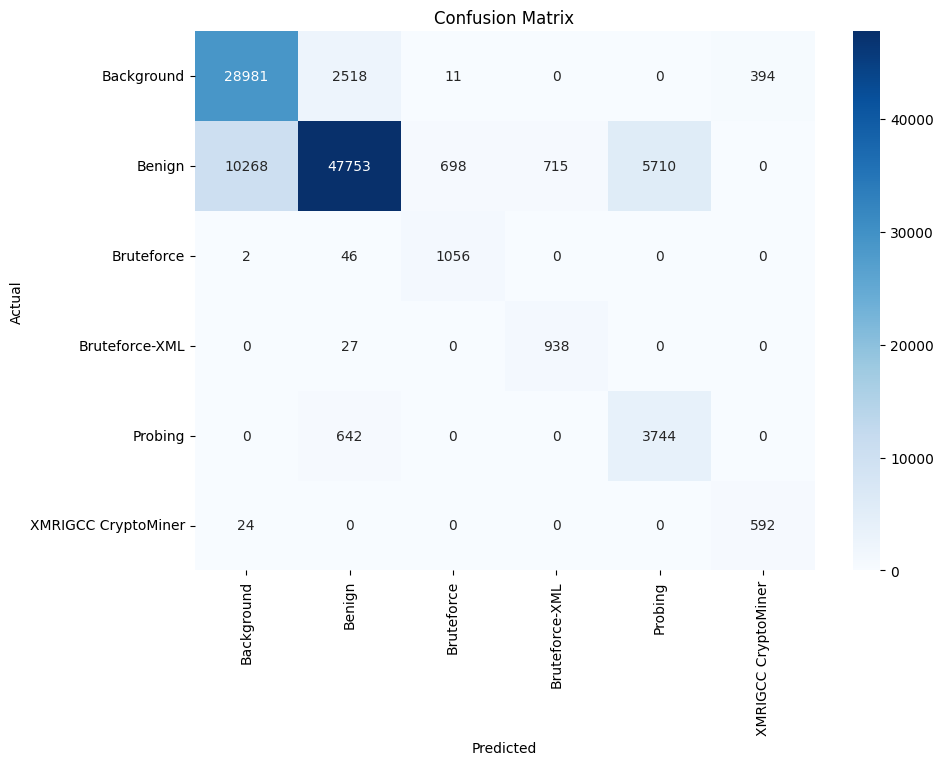

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=traffic_le.classes_, yticklabels=traffic_le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Submission

In [ ]:
test_clean_dmatrix = xgb.DMatrix(data=test_clean.drop('id',axis=1))
test_clean_pred = model.predict(test_clean_dmatrix)
test_clean_pred = traffic_le.inverse_transform(test_clean_pred.astype(int))
submisi_df = pd.DataFrame({
    'id': test['id'],
    'traffic': test_clean_pred
})
submisi_df.to_csv('submission51.csv', index=False)
submisi_df

id     traffic
0       ClDOIi3yLGMfeRPzAc      Benign
1       C9chsd1cHTOBBHe6Q2  Background
2       CUOe3U1NC5Nln7cItf      Benign
3       C6QhB04KTRUYOY2rMk      Benign
4       C60oC51SZNEhCXlX6c     Probing
...                    ...         ...
138800  CWXgM92AOvagYVekD3      Benign
138801  CMmDuU3aNTnOz4ZwSi  Background
138802  CQO5h64B0lXTYRlsNf      Benign
138803  CWZZN23jtBV7sZsBLi      Benign
138804  CAYAeJ26bhNrdT6KVc      Benign

[138805 rows x 2 columns]